# We are not providing you with any code for this assignment, so you must code everything yourself. However, we are providing you with an example notebook on how to run an MCMC.
# Furthermore, we provide a noise-free and noisy reference model from which you must derive parameters. Lastly, we give you three noisy covariance matrices.
# We recommend running the MCMC not in a Jupyter Notebook but instead using an external Python script.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import corner
import numpy as np
from numpy.linalg import inv
from cosmopower import cosmopower_NN
import tensorflow as tf
import gc
import emcee
import mycolorpy
from mycolorpy import colorlist as mcp
import pickle
%matplotlib inline

In [5]:
cov=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/covariance.npy')
cov_inv = inv(cov)

minimum=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/minimum.npy')
maximum=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/maximum.npy')

reference_model = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/reference_model.npy')
reference_model_noisy = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/reference_model_noise.npy')

cp_nn_model = cosmopower_NN(restore=True, restore_filename='drive/MyDrive/Colab Notebooks/data_4_assignment3/emulator_final')

cov_num_1500 = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/cov_num_1500.npy')
cov_num_3000 = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/cov_num_3000.npy')
cov_num_10000 = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/cov_num_10000.npy')

In [6]:
#which paramters we want to vary
parameters = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/parameters.npz')
param_names_varying = parameters.files
ndim = len(param_names_varying)
labels = [r"$\Omega_m$", r"$\Omega_b$", r"$A_s$", r"$w$"]

In [7]:
par_true = [np.mean(parameters['omega_m']), np.mean(parameters['omega_b']), np.mean(parameters['As']), np.mean(parameters['w'])]

## You can use any sampler you like to use for the following tasks. Also, you can use your own emulator. You must use the noisy reference model for the first three tasks. *Check for each task that the posteriors and the $\chi^2$ distributions are as expected.*
## Your tasks for this week are the following:

### 1. Run an MCMC where you vary all four parameters you have trained on your emulator.
### 2. Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.
### 3. Next, we consider PCA data compression. Run an MCMC for several numbers of PCA elements. Link your results to assignment two.
####    3.a. Use the analytical covariance matrix.
####    3.b. Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?
### 4. Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding $\chi^2$ distributions?
#### 4.a Plot and compare the marginalised constraints on $\Omega_\mathrm{m}$ and $A_s$, as a function of the number of PCA elements. What do you observe?
#### 4.b To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5 covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on $\Omega_\mathrm{m}$ and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

### 5. Bonus: Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.
###

# Task 1
Run an MCMC where you vary all four parameters you have trained on your emulator.

In [8]:
nwalkers = 100
def start_position_lh_and_step_size(seed): #random initial point in parameter space
    random.seed(seed)
    p0 = []
    for i in range(nwalkers):
        random_starts = []

        for name in param_names_varying:
            lower_edge = np.min(parameters[name])
            upper_edge = np.max(parameters[name])
            '''if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01'''

            random_starts.append(random.uniform(lower_edge,upper_edge))

        p0.append(random_starts)

    return np.array(p0)

In [9]:
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf

    return lnprior

## Function that computes the likelihood
def calc_likelihood(para, reference_model, cov_inv):

    params = {}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum

    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)

    delta = pred_vector - reference_model
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

### Run chain!

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood, args=(reference_model_noisy, cov_inv))

In [ ]:
# run MCMC
p0 = start_position_lh_and_step_size(5243)
sampler.run_mcmc(p0, 2200, progress='notebook');

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task1.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze Chain!

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task1.pickle', 'rb') as f:
    sampler = pickle.load(f)

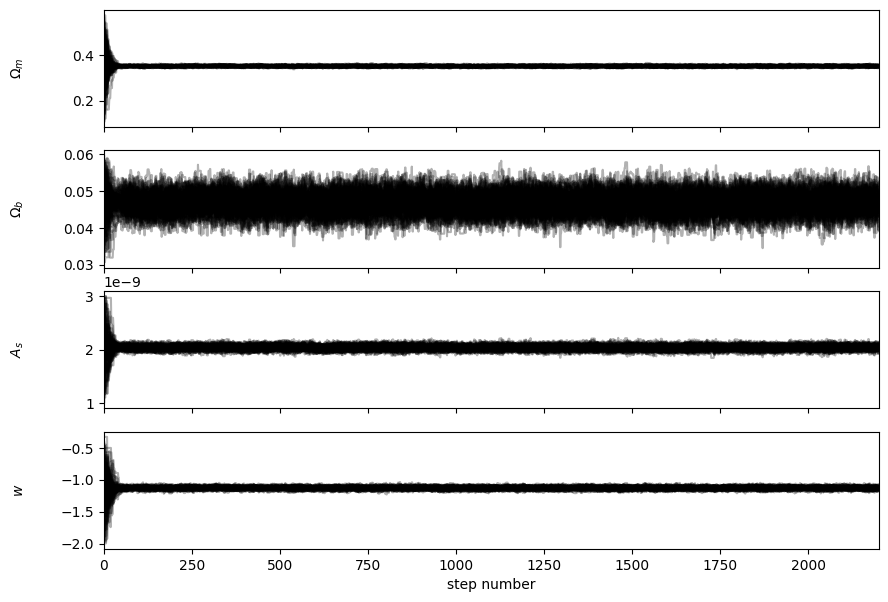

In [ ]:
ndim = 4 #parameters
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

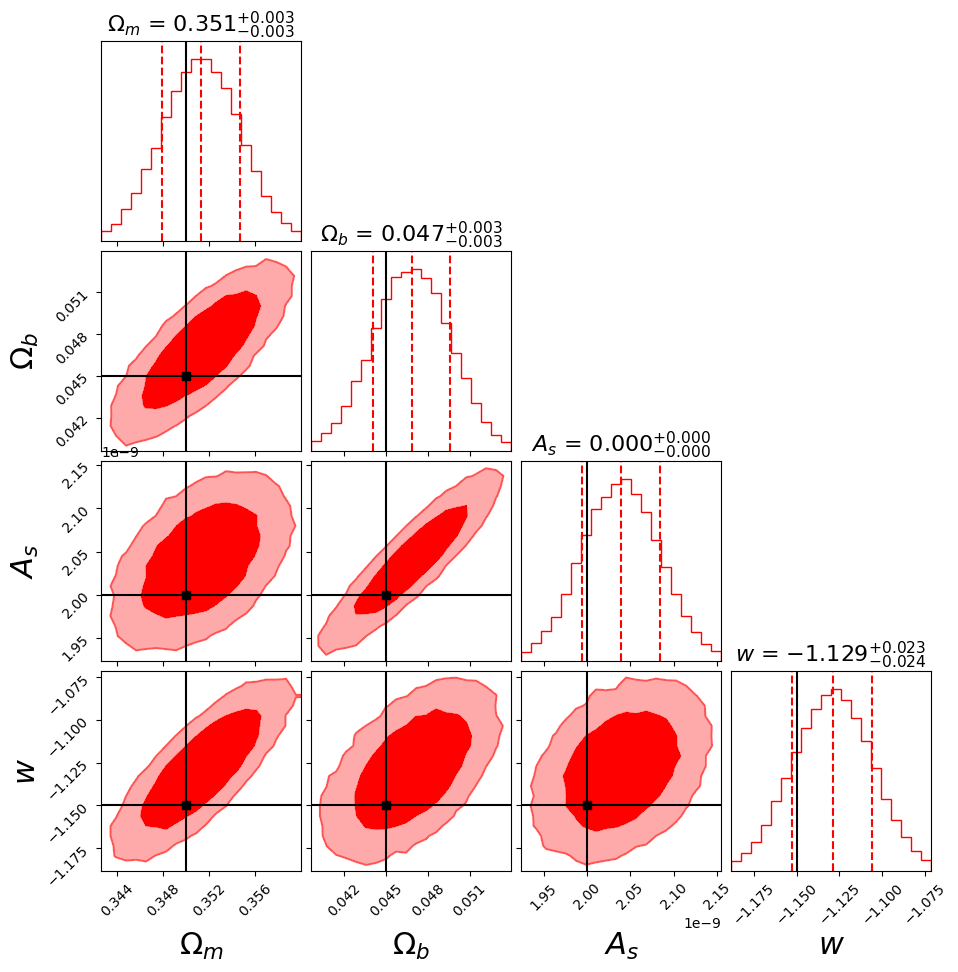

In [ ]:
flat_samples = sampler.get_chain(discard=200, thin=1, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, range=[0.99]*4, truths = par_true, truth_color='black'
)

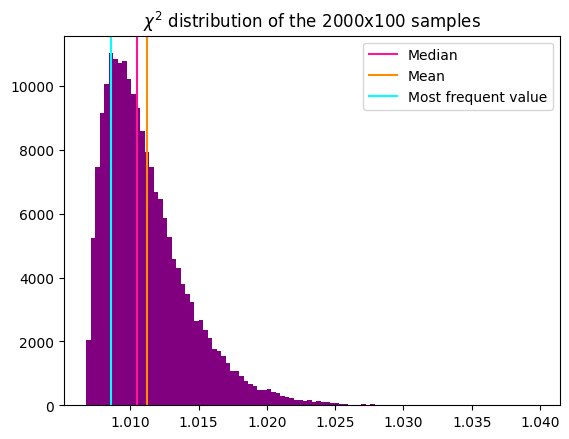

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2,bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 2000x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)

Median:  1.0104841890188399
Mean:  1.0111988761860435
Most frequent value:  1.0085776673068985


The best estimates for the 4 cosmological parameters from the MCMC chain recover the true cosmology within $1\sigma$. As expected, the true cosmology isn't recovered exactly as I am using the noisy reference model. The correct functioning of the chain is also supported by the reduced $\chi^2$ distribution for the samples: the values are distribued around 1, with median and mean value reported above.

# Task 2
Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.

## $1.5k$ covariance matrix

### Run Chain without Hartlap!

In [ ]:
parameters = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/parameters.npz')
param_names_varying = parameters.files
ndim = 4
nwalkers = 100
cov_inv_1500 = inv(cov_num_1500)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood, args=(reference_model_noisy, cov_inv_1500))

In [ ]:
p0 = start_position_lh_and_step_size(5243)
sampler.run_mcmc(p0, 2200, progress='notebook');

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze chain!

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500.pickle', 'rb') as f:
    sampler = pickle.load(f)

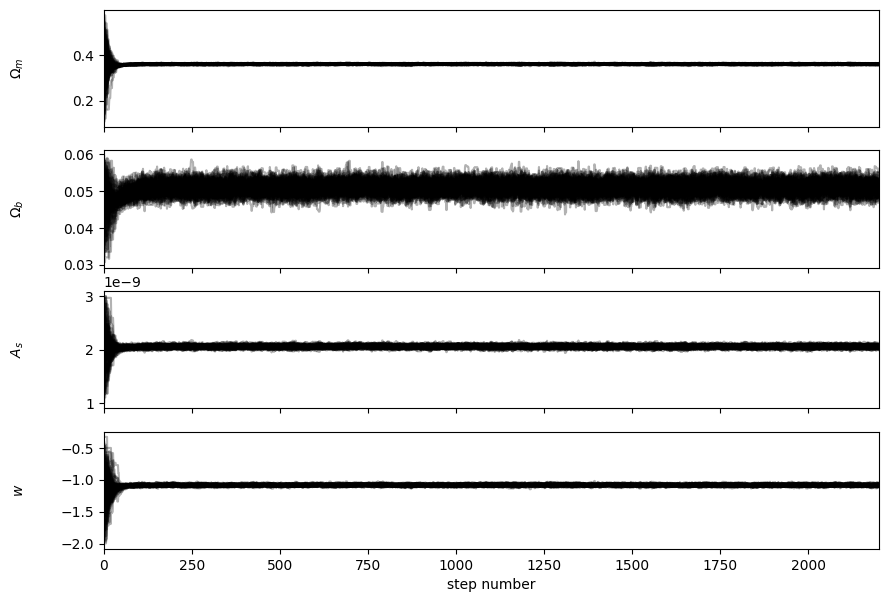

In [ ]:
ndim = 4 #parameters
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

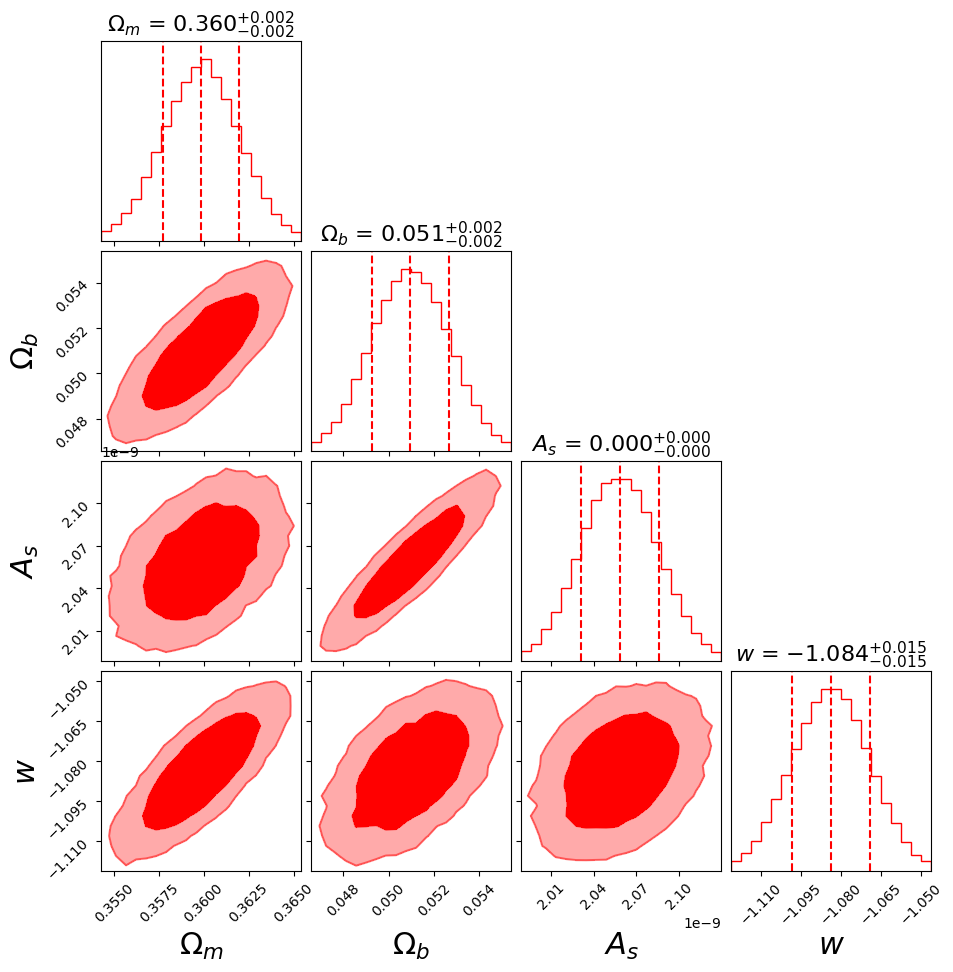

In [ ]:
flat_samples = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, range=[0.99]*4
)

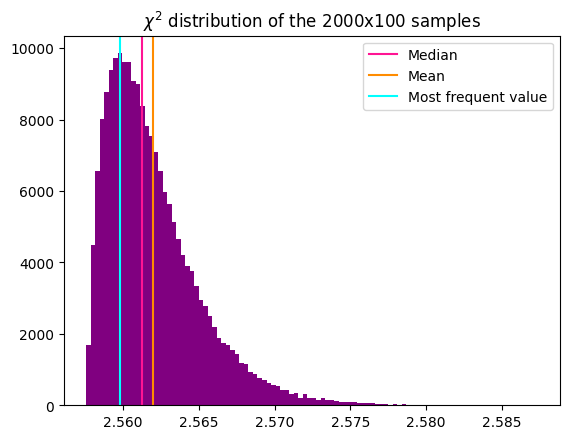

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2,bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 2000x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)

Median:  2.561290353411284
Mean:  2.562000440244778
Most frequent value:  2.559805472354242


The cornerplot doesn't show the true cosmology as the MCMC chain converges to values that are pretty far from that, as reinforced by the $\chi^2$ distribution, which has a mean value of 2.5 instead of the expected 1. This is to be expected as this is the worst scenario: I'm using a covariance matrix with only 1500 realizations (this isn't enough considering that the data vector has 900 entries) and I'm not including the hartlap correction factor.

### Run chain with hartlap!

In [ ]:
n_r = 1500
n_d = 900
h = (n_r-n_d-2)/(n_r-1)
cov_inv_1500 = inv(cov_num_1500)*h

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood, args=(reference_model_noisy, cov_inv_1500))

In [ ]:
p0 = start_position_lh_and_step_size(654)
sampler.run_mcmc(p0, 2200, progress='notebook');

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500_hartlap.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze chain!

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500_hartlap.pickle', 'rb') as f:
    sampler = pickle.load(f)

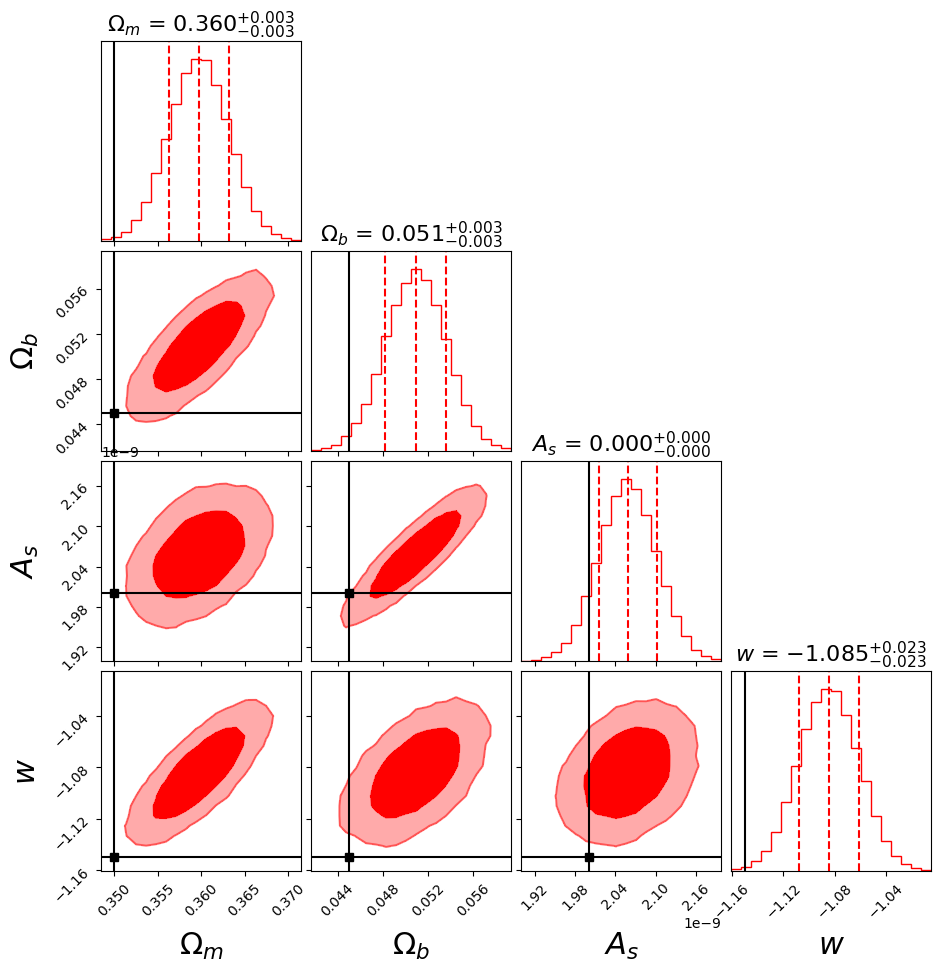

In [ ]:
flat_samples = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, range=[0.999]*4, truths = par_true, truth_color='black'
)

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2[chi2<1.06],bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 2000x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)
print(rf"Number of elements with chi^2 >1.06: ", np.size(chi2[chi2>1.06]))

Median:  1.0240209502738198
Mean:  1.0251340213792615
Most frequent value:  1.0227181178262326
Number of elements with chi^2 >1.06:  54


The Hartlap correction definitely helps in recovery the true cosmology, which is found to be within 2-3$\sigma$. The distribution of $\chi^2$ values also improves, with most values laying around 1.02. Nonetheless, there are a few outliers with $\chi^2 \approx 2$, indicating that a few walkers get stuck in local minima.

### Comparison with-without Hartlap factor

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500_hartlap.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

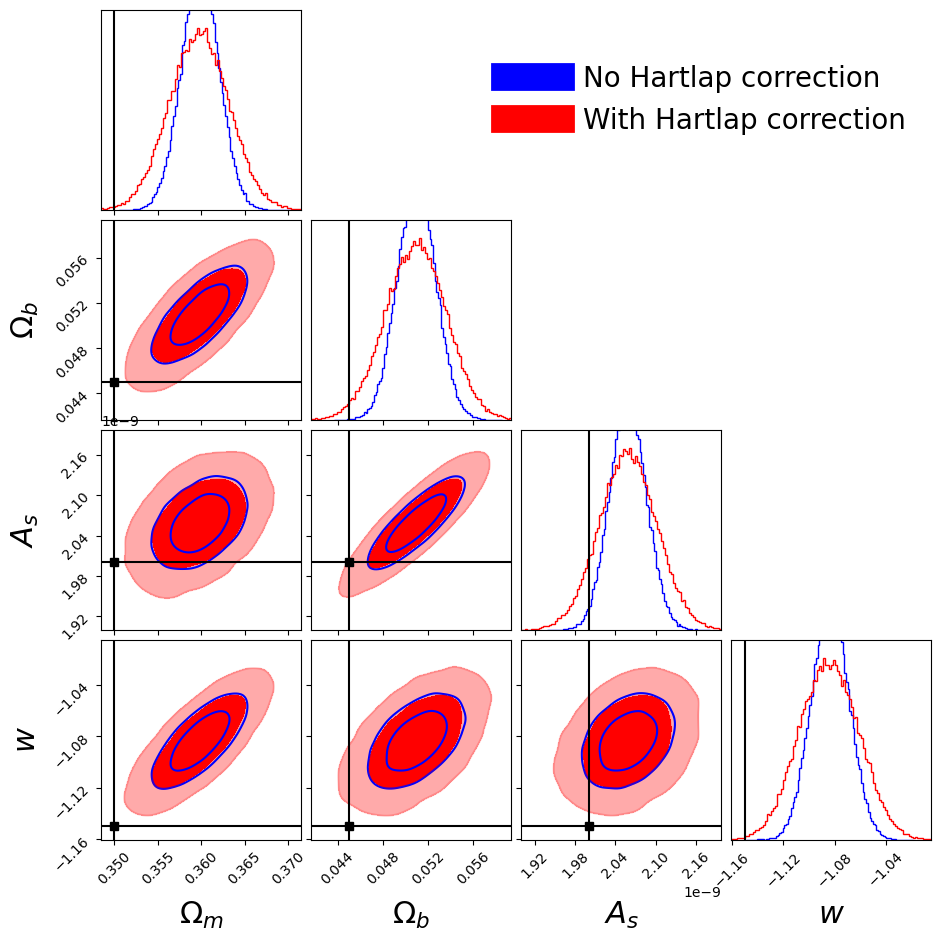

In [ ]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color="blue", label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 1},plot_datapoints=False, smooth=3)
corner.corner(flat_samples_2,bins=100,labels=labels, color="red", label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 0.2},plot_datapoints=False, smooth=3,range=[0.999] * 4, truths = par_true, truth_color='black')


plt.legend(
        handles=[Line2D([], [], color='blue', label=r'No Hartlap correction',linewidth=20),
                 Line2D([], [], color="red", label=r'With Hartlap correction',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(1, 4, 0, 0)
    )


plt.show()

By de-biasing the covariance matrix with the Hartlap factor, we get a more accurate estimate of the error bars, which where underestimated in the first case, as evident from the above cornerplot.

## $3k$ covariance matrix

### Run chain without Hartlap!

In [ ]:
cov_inv_3000 = inv(cov_num_3000)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood, args=(reference_model_noisy, cov_inv_3000))

In [ ]:
p0 = start_position_lh_and_step_size(9182763)
sampler.run_mcmc(p0, 2200, progress='notebook')

  0%|          | 0/2200 [00:00<?, ?it/s]

State([[ 3.55495685e-01  4.91765479e-02  2.06688441e-09 -1.10066728e+00]
 [ 3.58927851e-01  5.00936609e-02  2.05785486e-09 -1.06200575e+00]
 [ 3.58453102e-01  5.20368198e-02  2.11292059e-09 -1.07232787e+00]
 [ 3.55085002e-01  4.98462586e-02  2.07954147e-09 -1.09601230e+00]
 [ 3.56082543e-01  4.94165490e-02  2.06756993e-09 -1.09462668e+00]
 [ 3.56591290e-01  5.34195314e-02  2.14950836e-09 -1.08784468e+00]
 [ 3.56386240e-01  5.31430278e-02  2.14749349e-09 -1.09245909e+00]
 [ 3.53534929e-01  4.73569538e-02  2.04128472e-09 -1.08314655e+00]
 [ 3.56604838e-01  4.98366603e-02  2.06787779e-09 -1.08567056e+00]
 [ 3.52182255e-01  4.75887228e-02  2.05259542e-09 -1.13245973e+00]
 [ 3.58267440e-01  5.22423536e-02  2.10680043e-09 -1.07439749e+00]
 [ 3.55105937e-01  5.09673170e-02  2.11138897e-09 -1.09808049e+00]
 [ 3.60549613e-01  5.11004044e-02  2.06916993e-09 -1.06430352e+00]
 [ 3.54559886e-01  5.04351204e-02  2.09890724e-09 -1.10214989e+00]
 [ 3.53276194e-01  4.83599626e-02  2.06860849e-09 -1.085

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze chain!

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000.pickle', 'rb') as f:
    sampler = pickle.load(f)

In [ ]:
ndim = 4 #parameters
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, range=[0.999]*4, truths = par_true, truth_color='black'
)

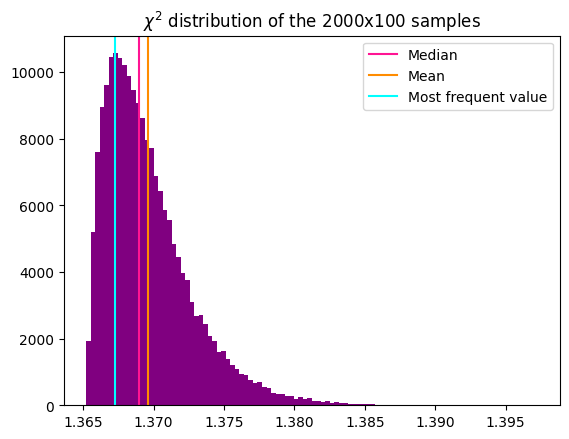

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2,bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 2000x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)

Median:  1.368923139888406
Mean:  1.3696264190518208
Most frequent value:  1.3672843316585856


Using a more reliable covariance matrix, even if not Hartlap corrected, actually improves the MCMC estimates, which are, in most cases, within 2$\sigma$ from the true cosmology. The $\chi^2$ values are distributred around 1.36: this is better than the previous case but still needs to be improved!

### Run chain with Hartlap!

In [ ]:
n_r = 3000
n_d = 900
h = (n_r-n_d-2)/(n_r-1)
cov_inv_3000 = inv(cov_num_3000)*h

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood, args=(reference_model_noisy, cov_inv_3000))

In [ ]:
p0 = start_position_lh_and_step_size(9182763)
sampler.run_mcmc(p0, 2200, progress='notebook');

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000_hartlap.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze chain!

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000_hartlap.pickle', 'rb') as f:
    sampler = pickle.load(f)

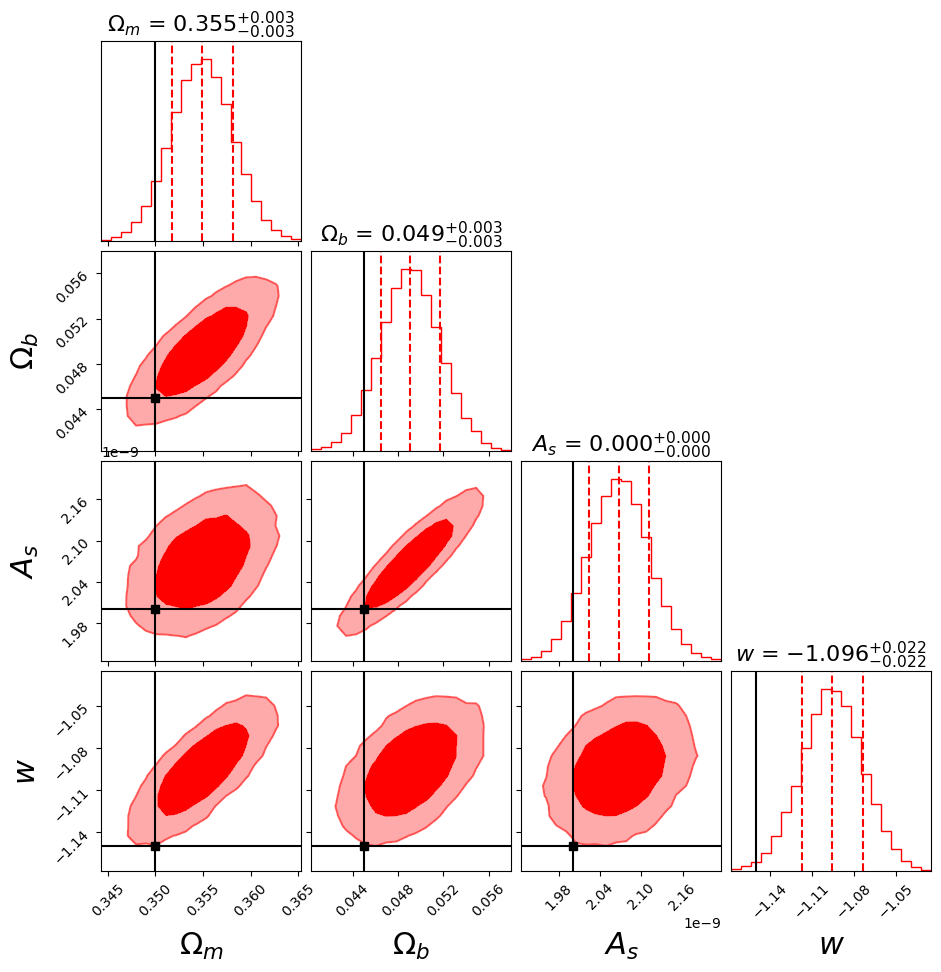

In [ ]:
flat_samples = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, range=[0.999]*4, truths = par_true, truth_color='black'
)

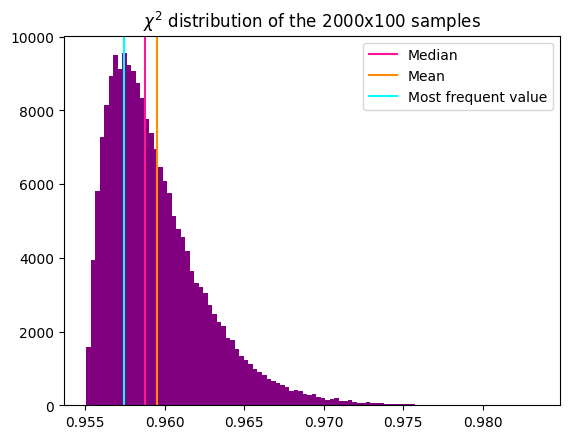

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2,bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 2000x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)

Median:  0.9587594412706376
Mean:  0.9594808692230917
Most frequent value:  0.9574604964901752


Once again, adding the Hartlap correction to the covariance matrix really helps: the $\chi^2$ values are distributed around 0.95. This is still not perfect, as we would expect since we're using the 3k covariance matrix.

### Comparison with-without Hartlap factor

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000_hartlap.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

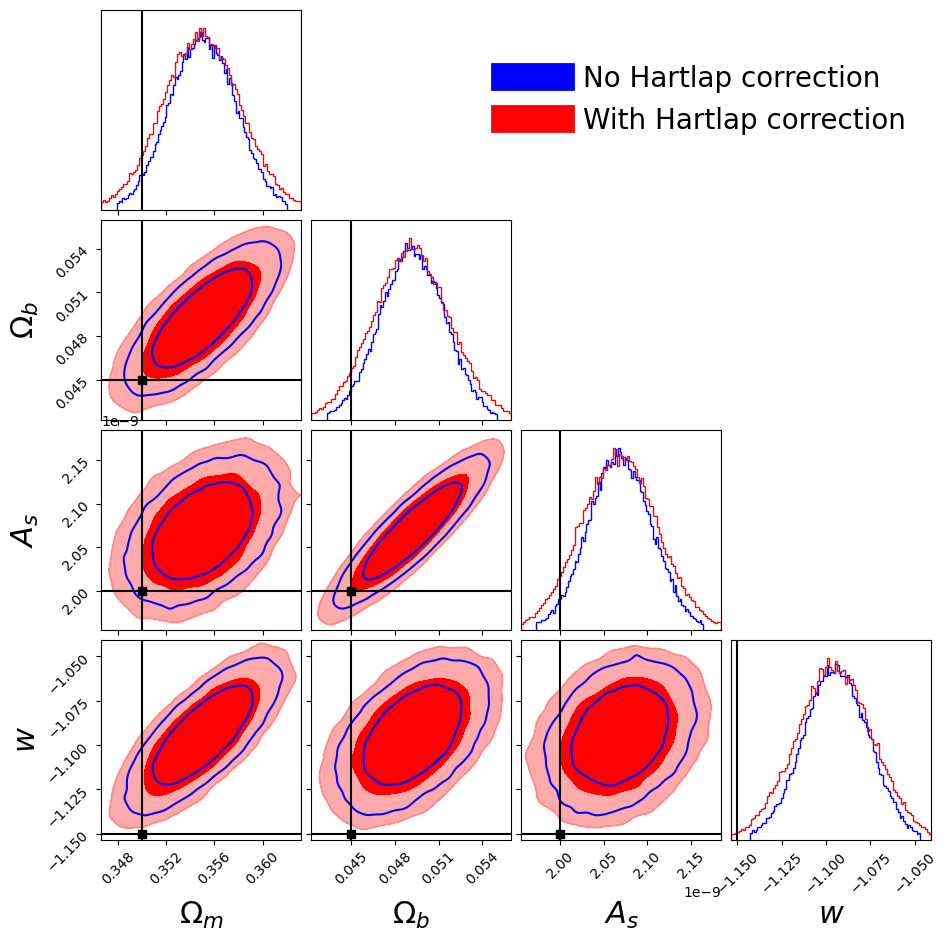

In [ ]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color="blue", label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 1},plot_datapoints=False, smooth=3,range=[0.99] * 4)
corner.corner(flat_samples_2,bins=100,labels=labels, color="red", label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 0.2},plot_datapoints=False, smooth=3,range=[0.99] * 4, truths = par_true, truth_color='black')


plt.legend(
        handles=[Line2D([], [], color='blue', label=r'No Hartlap correction',linewidth=20),
                 Line2D([], [], color="red", label=r'With Hartlap correction',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(1, 4, 0, 0)
    )


plt.show()

As in the case of the 1.5k covariance matrix, with the Hartlap correction factor the error bars are not underestimated anymore. This effect is less strong than before, because the covariance matrix is more reliable to begin with, as it is made with more realizations. In fact, the 1.5k covariance matrix is multiplied by a factor h=0.39, while in this case h=0.69.

## $10k$ covariance matrix

### Run chain without Hartlap

In [ ]:
cov_inv_10000 = inv(cov_num_10000)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood, args=(reference_model_noisy, cov_inv_10000))

In [ ]:
p0 = start_position_lh_and_step_size(654)
sampler.run_mcmc(p0, 2200, progress='notebook');

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze chain!

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000.pickle', 'rb') as f:
    sampler = pickle.load(f)

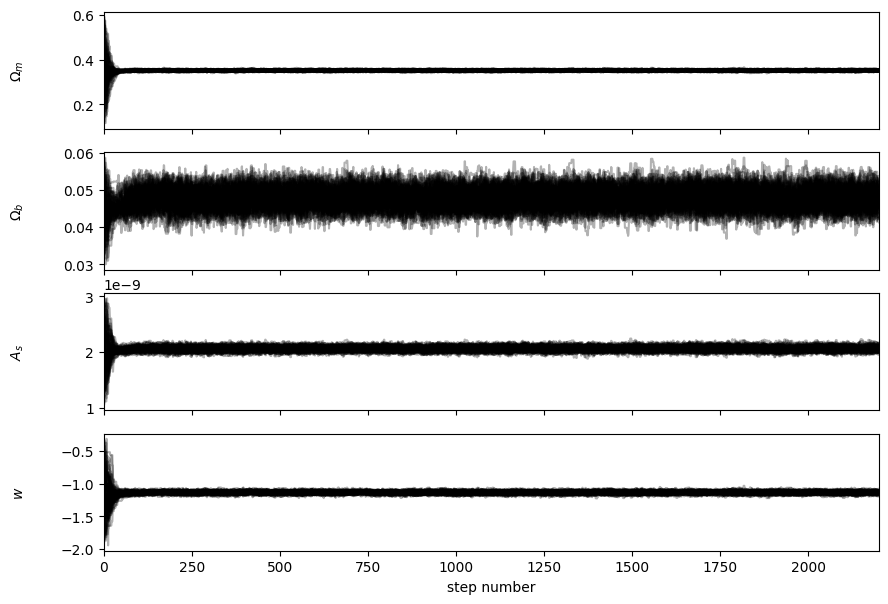

In [ ]:
ndim = 4 #parameters
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

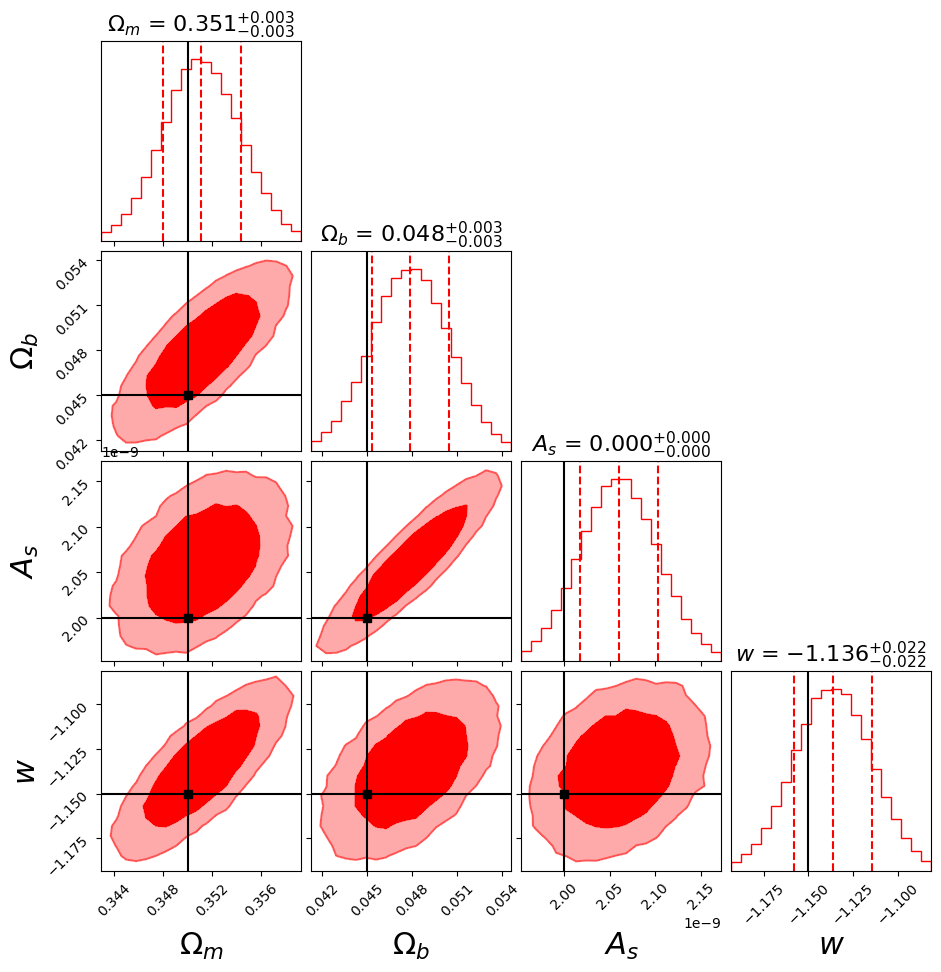

In [ ]:
flat_samples = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, range=[0.99]*4,  truths = par_true, truth_color='black'
)

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2,bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 2000x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)

Median:  1.0885739599782434
Mean:  1.0892831929768816
Most frequent value:  1.0869483555597141


Using a reliable covariance matrix, even if not Hartlap corrected, actually improves the MCMC estimates, which are now within 1$\sigma$ from the true cosmology. The $\chi^2$ values are distributred around 1.08: finally, very close to 1! Again, the true cosmology is not exactly recovered, but that's bevause we are using the noisy reference model.

### Run chain with Hartlap!

In [ ]:
n_r = 10000
n_d = 900
h = (n_r-n_d-2)/(n_r-1)
cov_inv_10000 = inv(cov_num_10000)*h

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood, args=(reference_model_noisy, cov_inv_10000))

In [ ]:
p0 = start_position_lh_and_step_size(654)
sampler.run_mcmc(p0, 2200, progress='notebook');

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000_hartlap.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze chain!

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000_hartlap.pickle', 'rb') as f:
    sampler = pickle.load(f)

In [ ]:
ndim = 4 #parameters
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=200, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, range=[0.99]*4, truths = par_true, truth_color='black'
)

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2,bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 2000x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)

Median:  0.9908333897319814
Mean:  0.9915495799772872
Most frequent value:  0.989720470786279


In this case, the hartlap correction factor is h = 0.9, so it doesn't impact the result as strongly as in previous cases. The true cosmology is recovered within 1$\sigma$ and the $\chi^2$ values are distributed around 0.99.

### Comparison with-without Hartlap factor

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000_hartlap.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

In [ ]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color="blue", label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 1},plot_datapoints=False, smooth=3,range=[0.99] * 4)
corner.corner(flat_samples_2,bins=100,labels=labels, color="red", label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 0.2},plot_datapoints=False, smooth=3,range=[0.99] * 4, truths = par_true, truth_color='black')


plt.legend(
        handles=[Line2D([], [], color='blue', label=r'No Hartlap correction',linewidth=20),
                 Line2D([], [], color="red", label=r'With Hartlap correction',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(1, 4, 0, 0)
    )


plt.show()

The above cornerplot shows how, once again, adding the Hartlap correction causes an increase in the error bars. In this case, the effect is very slight since the 10k covariance matrix has enough realization to be considered reliable (10k >> 900!)

## Total plot without hartlap

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

In [ ]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
flat_samples_3 = sampler3.get_chain(discard=200, flat=True)

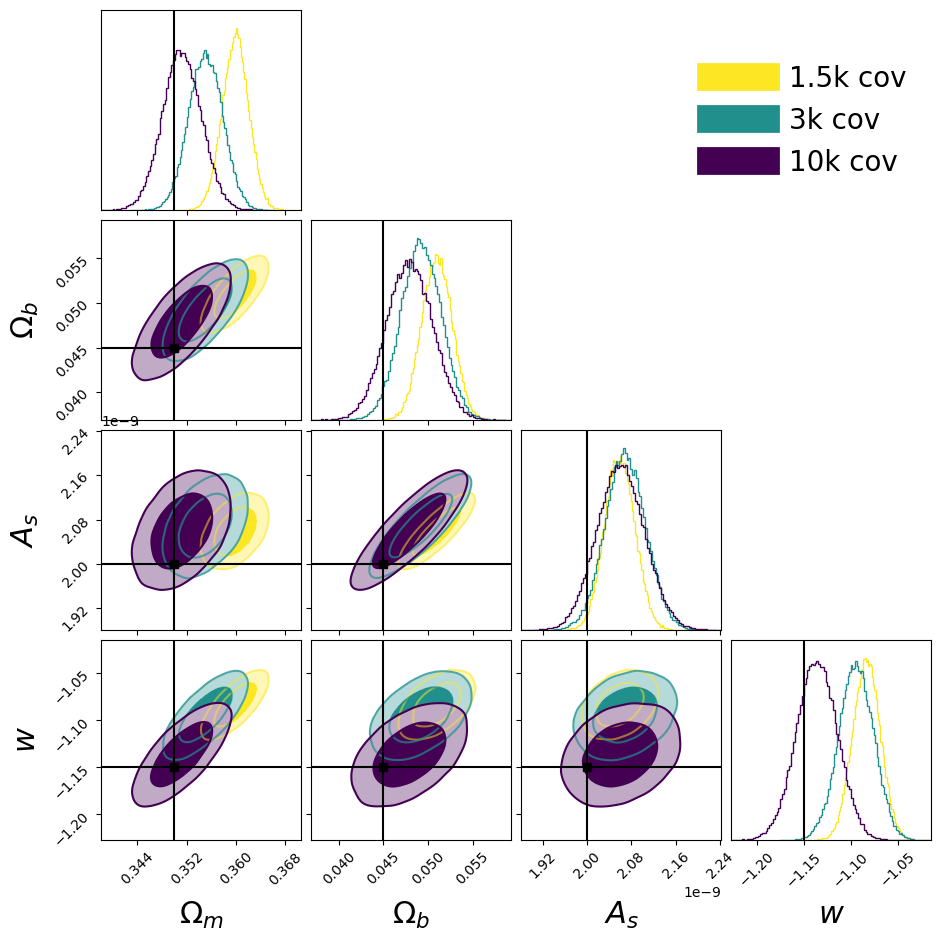

In [ ]:
colors = mcp.gen_color(cmap="viridis_r",n=3)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, smooth=3)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 0.7},plot_datapoints=False, smooth=3)
corner.corner(flat_samples_3,bins=100,labels=labels, color=colors[2], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 1},plot_datapoints=False, smooth=3, truths = par_true, truth_color='black')

plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'1.5k cov',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'3k cov',linewidth=20),
                 Line2D([], [], color=colors[2], label=r'10k cov',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(1, 4, 0, 0)
    )

It is clear from this plot that the employment of an unreliable covariance matrix (unrealiable meaning estimated with too few realizations) not only cause an underestimation of the error bars, but also delivers a biased estimate of the cosmological parameters.

## Total plot with hartlap

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_1500_hartlap.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_3000_hartlap.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task2_10000_hartlap.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

In [ ]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
flat_samples_3 = sampler3.get_chain(discard=200, flat=True)

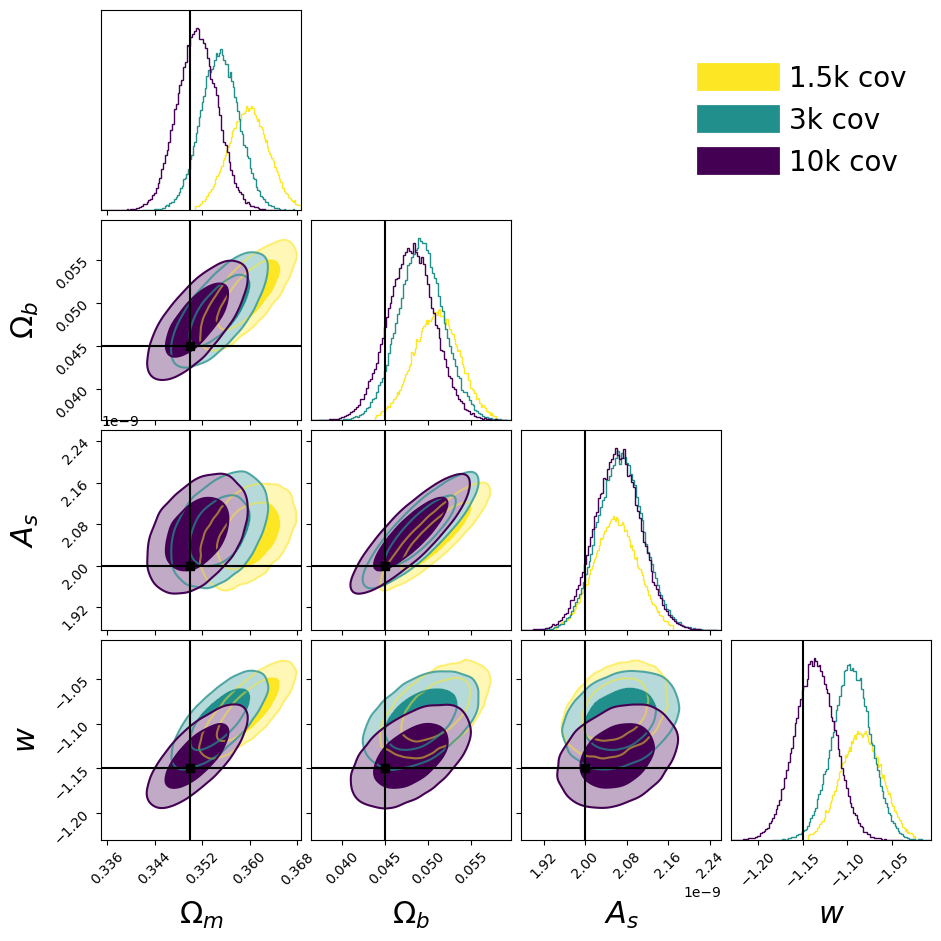

In [ ]:
colors = mcp.gen_color(cmap="viridis_r",n=3)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, smooth=3,range=[0.99] * 4)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 0.7},plot_datapoints=False, smooth=3)
corner.corner(flat_samples_3,bins=100,labels=labels, color=colors[2], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True, contour_kwargs={"alpha": 1},plot_datapoints=False, smooth=3, truths = par_true, truth_color='black')

plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'1.5k cov',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'3k cov',linewidth=20),
                 Line2D([], [], color=colors[2], label=r'10k cov',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(1, 4, 0, 0)
    )

This plot shows the impact of the Hartlap correction factor, which allows for a correct estimation of the error bars. In fact, in the three cases the error bars are roughly of the same size. However, using too few realizations for the covariance matrix introduces a bias in the estimated cosmological paramteres that isn't fixed by the Hartlap correction, stressing the importance of the covariance matrix in the likelihood analysis.

#### _Link to assignment 1_
In assignment 1, we investigated the covariance matrices and the impact of the Hartlap correction factor. We verified that some noisy data models generated from a multivariate Gaussian follow a $\chi^2$ distribution when a theoretical covariance matrix is used. We then used the noisy models to compute numerical covariances using different numbers of realizations and tested if we could recover the expected $\chi^2$ distribution. What we learned from that is:
- For the covariance matrix to be reliable, we need to use a lot of realizations. The general criteria is N >> dof.
- De-biasing the inverse covariance matrix with the Hartlap correction is very important: the numerical covarainces are biased as they are themselves random variable.
In summary, we can recover the expected $\chi^2$ distribution only using the numerical covariance with 10k realizations and by using the Hartlap correction factor to de-bias its inverse.

The chains that I run in task 2 confirmed this behaviour: when the hartlap correction factor is left out, the error bars are systematically underestimated. Moreover, an unreliable covariance matrix leads to a biased estimate of the cosmological parameters.

# Task 3
Run an MCMC for several numbers of PCA elements. Link your results to assignment two.
- 3.a: Use the analytical covariance matrix.
- 3.b: Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?

In [10]:
from sklearn.decomposition import PCA

In [11]:
N_pca = 900
models = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/models.npy')
mean = np.mean(models,axis=0)
pca = PCA(n_components = N_pca, svd_solver='full')
models_pca = pca.fit_transform(models-mean)
rotation_matrix = pca.components_.T

In [12]:
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf

    return lnprior

## Function that computes the likelihood
def calc_likelihood_pca(para, reference_model, cov_inv, N_pca):

    params = {}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    features = cp_nn_model.predictions_np(params)[0]
    features = features*maximum+minimum
    pred_vector = pca.transform((features-mean).reshape(1,-1))[0,:N_pca]


    delta = (pred_vector - reference_model)
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

## 3.a: analytical covariance matrix

In [13]:
cov=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/covariance.npy')
cov_inv = inv(cov)
cov_pca = rotation_matrix.T @ cov @ rotation_matrix

In [14]:
def run_mcmc_pca(N_pca, cov_pca, reference_model):
  inv_cov_pca = inv(cov_pca[:N_pca,:N_pca])
  reference_model = pca.transform((reference_model-mean).reshape(1,-1))[0,:N_pca]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood_pca, args=(reference_model, inv_cov_pca, N_pca))
  p0 = start_position_lh_and_step_size(654)
  sampler.run_mcmc(p0, 2200, progress='notebook')
  with open(f'drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_{str(N_pca)}.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Calculate chains

In [ ]:
run_mcmc_pca(100, cov_pca, reference_model_noisy)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(200, cov_pca, reference_model_noisy)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(300, cov_pca, reference_model_noisy)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model_noisy)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(700, cov_pca, reference_model_noisy)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(800, cov_pca, reference_model_noisy)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(900, cov_pca, reference_model_noisy) #sanity check, should deliver same result as task 1!

  0%|          | 0/2200 [00:00<?, ?it/s]

### Plot contours

In [15]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_100.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_200.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_300.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_500.pickle', 'rb') as f:
    sampler4 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_700.pickle', 'rb') as f:
    sampler5 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_800.pickle', 'rb') as f:
    sampler6 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task1.pickle', 'rb') as f:
    sampler7 = pickle.load(f)

In [16]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
flat_samples_3 = sampler3.get_chain(discard=200, flat=True)
flat_samples_4 = sampler4.get_chain(discard=200, flat=True)
flat_samples_5 = sampler5.get_chain(discard=200, flat=True)
flat_samples_6 = sampler6.get_chain(discard=200, flat=True)
flat_samples_7 = sampler7.get_chain(discard=200, flat=True)

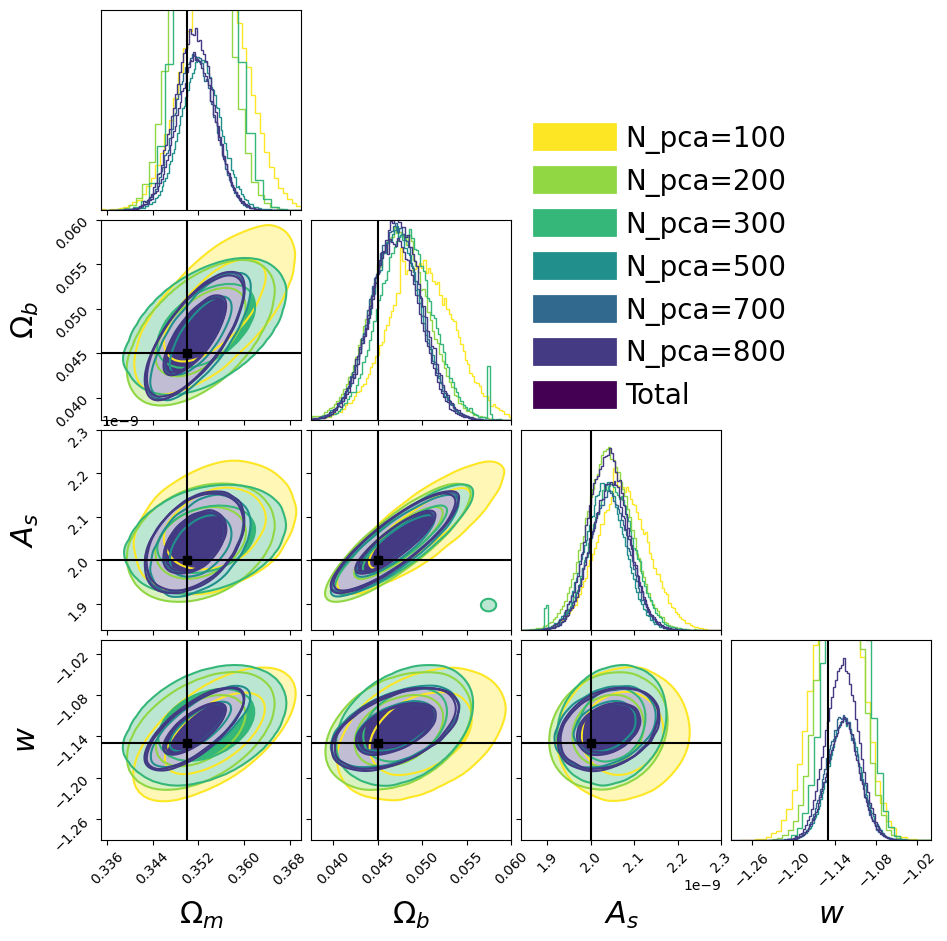

In [17]:
colors = mcp.gen_color(cmap="viridis_r",n=7)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_3,bins=100,labels=labels, color=colors[2], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_4,bins=100,labels=labels, color=colors[3], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_5,bins=100,labels=labels, color=colors[4], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_6,bins=100,labels=labels, color=colors[5], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_7,bins=100,labels=labels, color=colors[5], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3, truths = par_true, truth_color='black', range = [(0.335,0.37), (0.0375,0.06), (1.84e-9,2.3e-9), (-1.29,-1)])


plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'N_pca=100',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'N_pca=200',linewidth=20),
                 Line2D([], [], color=colors[2], label=r'N_pca=300',linewidth=20),
                 Line2D([], [], color=colors[3], label=r'N_pca=500',linewidth=20),
                 Line2D([], [], color=colors[4], label=r'N_pca=700',linewidth=20),
                 Line2D([], [], color=colors[5], label=r'N_pca=800',linewidth=20),
                 Line2D([], [], color=colors[6], label=r'Total',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(0.4, 3.7, 0, 0)
    );




We can see from this cornerplot that by increasing the number of PCA elements, the error bars decrease. This makes sense, as with too few PCA elements considered, we're actually loosing a lot of information from the data and that is reflected in the MCMC. We can also see that starting from the 500 elements PCA case, the contours are basically the same suggesting that almost all information in the data has been captured. The $\chi^2$ distributions below tell a similar story: when increasing the number of pca elements, the peak gets closer to 1, which is a sign of a good fit.

#### $\chi^2$ distributions

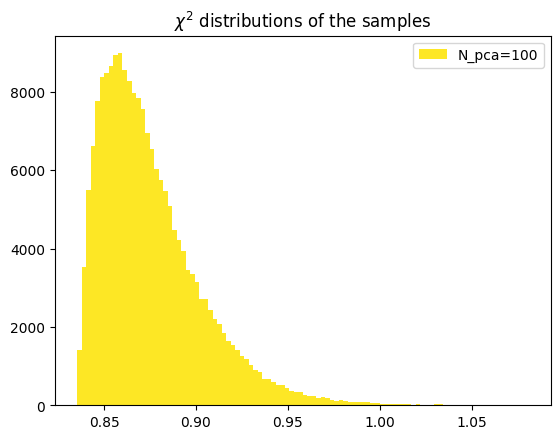

In [26]:
log_prob_samples_1 = sampler1.get_log_prob(discard=200, flat=True)
chi2_1 = -2*log_prob_samples_1/100
nc,bins,_=plt.hist(chi2_1[chi2_1<1.1],bins=100, color = colors[0], label = "N_pca=100")

plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

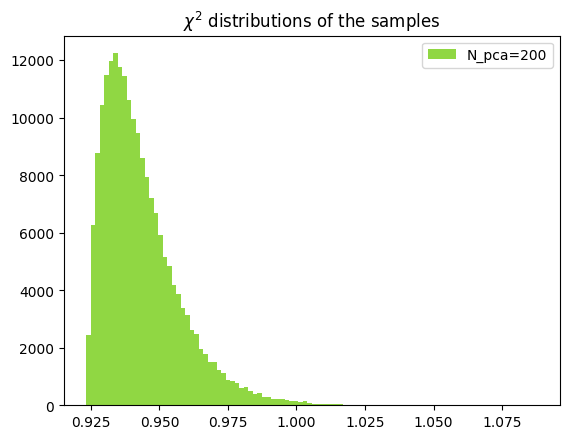

In [27]:
log_prob_samples_2 = sampler2.get_log_prob(discard=200, flat=True)
chi2_2 = -2*log_prob_samples_2/200
nc,bins,_=plt.hist(chi2_2[chi2_2<1.1],bins=100, color = colors[1], label = "N_pca=200")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

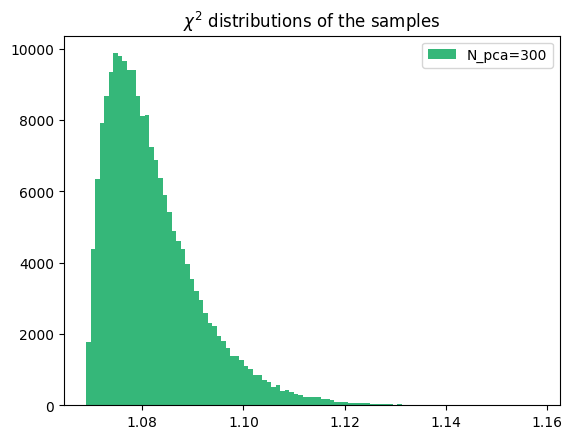

In [29]:
log_prob_samples_3 = sampler3.get_log_prob(discard=200, flat=True)
chi2_3 = -2*log_prob_samples_3/300
nc,bins,_=plt.hist(chi2_3[chi2_3<1.3],bins=100, color = colors[2], label = "N_pca=300")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

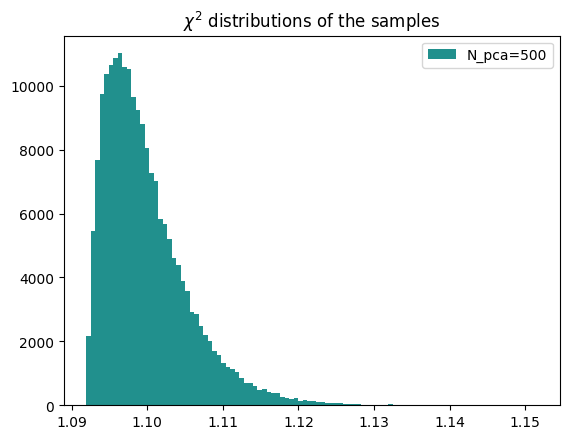

In [30]:
log_prob_samples_4 = sampler4.get_log_prob(discard=200, flat=True)
chi2_4 = -2*log_prob_samples_4/500
nc,bins,_=plt.hist(chi2_4,bins=100, color = colors[3], label = "N_pca=500")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

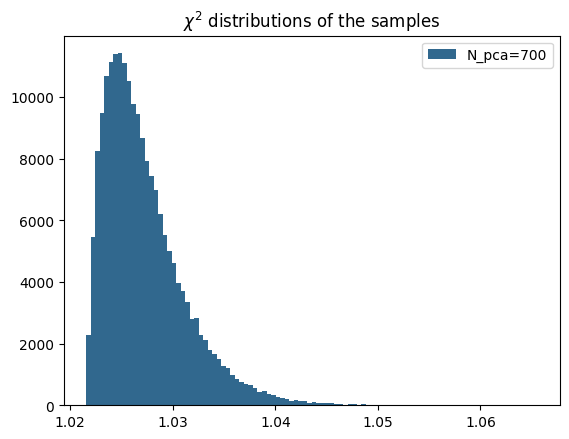

In [31]:
log_prob_samples_5 = sampler5.get_log_prob(discard=200, flat=True)
chi2_5 = -2*log_prob_samples_5/700
nc,bins,_=plt.hist(chi2_5,bins=100, color = colors[4], label = "N_pca=700")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

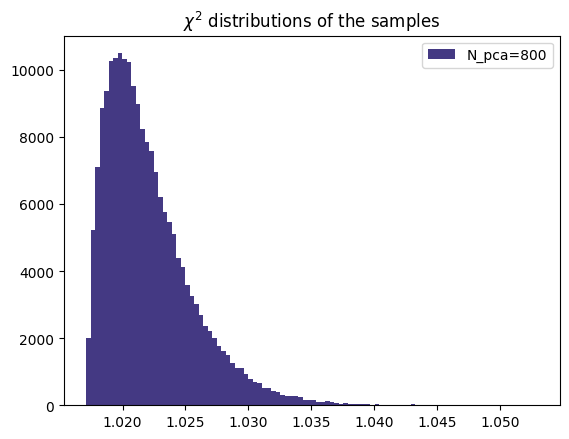

In [32]:
log_prob_samples_6 = sampler6.get_log_prob(discard=200, flat=True)
chi2_6 = -2*log_prob_samples_6/800
nc,bins,_=plt.hist(chi2_6,bins=100, color = colors[5], label = "N_pca=800")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

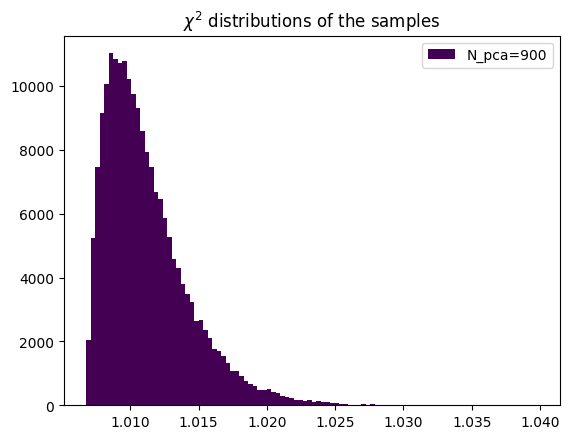

In [33]:
log_prob_samples_7 = sampler7.get_log_prob(discard=200, flat=True)
chi2_7 = -2*log_prob_samples_7/900
nc,bins,_=plt.hist(chi2_7,bins=100, color = colors[6], label = "N_pca=900")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

#### Sanity check

In [ ]:
## sanity check
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task1.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3_pca_900.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)

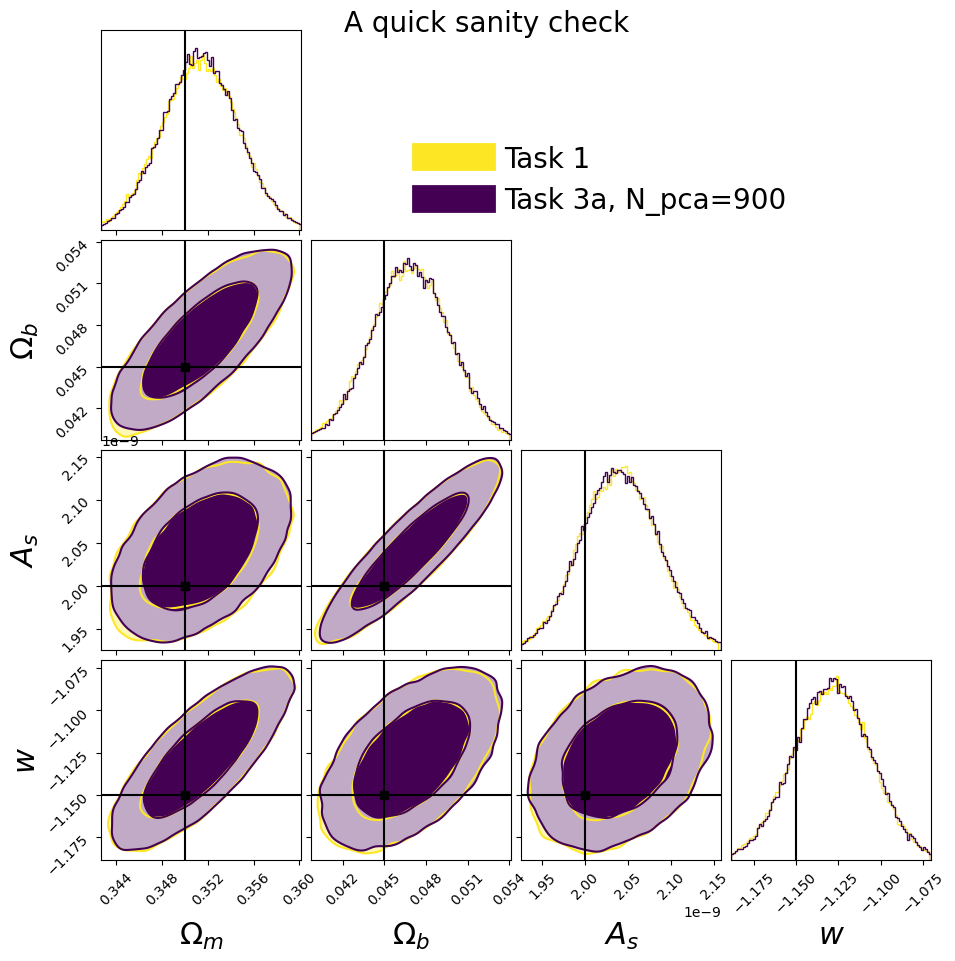

In [ ]:
colors = mcp.gen_color(cmap="viridis_r",n=2)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3, range=[0.99] * 4)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3, range=[0.99] * 4, truths = par_true, truth_color='black')



plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'Task 1',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'Task 3a, N_pca=900',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(0.4, 3.7, 0, 0)
    )
figure.suptitle("A quick sanity check", fontsize = 20);

Here I'm just checking that the PCA with 900 elements recovers the results from task 1, for consistency :)

## 3.b: 1.5k covariance matrix

In [34]:
cov = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/cov_num_1500.npy')
n_r = 1500
n_d = 900
h = (n_r-n_d-2)/(n_r-1)
cov_inv = inv(cov)*h
cov_pca = rotation_matrix.T @ cov @ rotation_matrix

In [35]:
def run_mcmc_pca(N_pca, cov_pca, reference_model):
  n_r = 1500
  n_d = N_pca
  h = (n_r-n_d-2)/(n_r-1)
  inv_cov_pca = inv(cov_pca[:N_pca,:N_pca])*h
  reference_model = pca.transform((reference_model-mean).reshape(1,-1))[0,:N_pca]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood_pca, args=(reference_model, inv_cov_pca, N_pca))
  p0 = start_position_lh_and_step_size(654)
  sampler.run_mcmc(p0, 1200, progress='notebook')
  with open(f'drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3B_pca_{str(N_pca)}.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Calculate chains

In [ ]:
run_mcmc_pca(100, cov_pca, reference_model_noisy)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(300, cov_pca, reference_model_noisy)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model_noisy)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(700, cov_pca, reference_model_noisy)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(900, cov_pca, reference_model_noisy)

  0%|          | 0/1200 [00:00<?, ?it/s]

### Plot contours

In [36]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3B_pca_100.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3B_pca_300.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3B_pca_500.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3B_pca_700.pickle', 'rb') as f:
    sampler4 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task3B_pca_900.pickle', 'rb') as f:
    sampler5 = pickle.load(f)

In [37]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
flat_samples_3 = sampler3.get_chain(discard=200, flat=True)
flat_samples_4 = sampler4.get_chain(discard=200, flat=True)
flat_samples_5 = sampler5.get_chain(discard=200, flat=True)

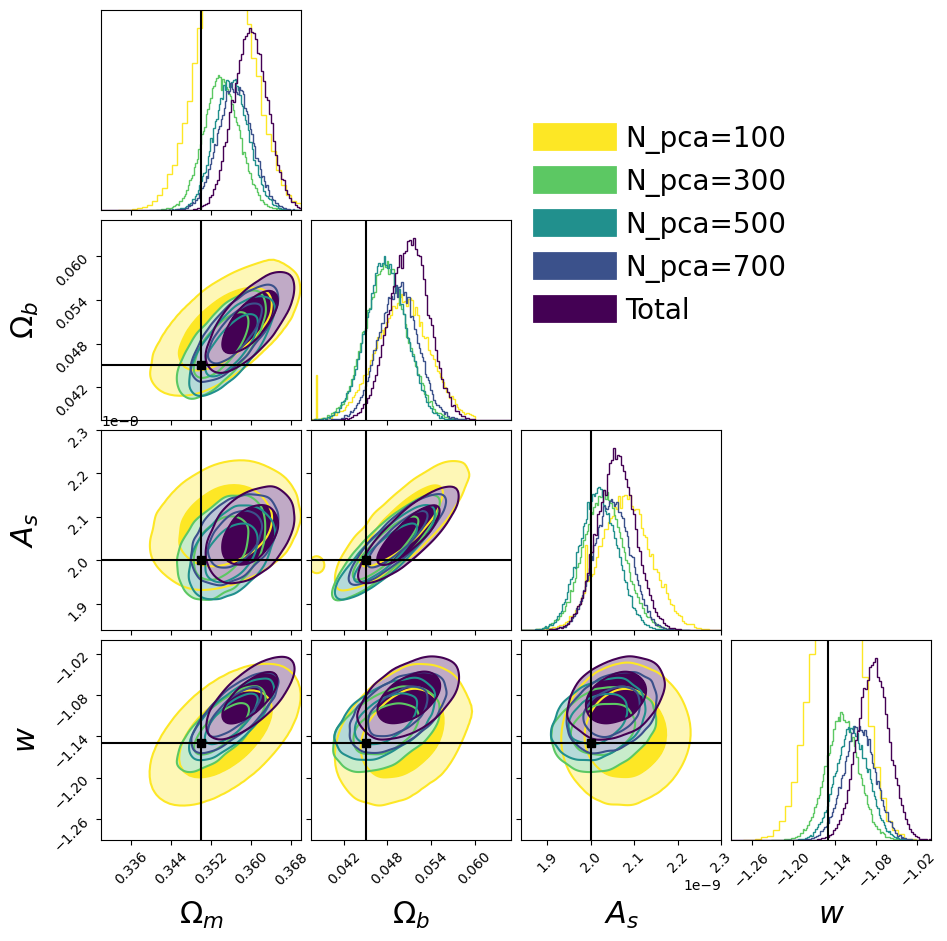

In [38]:
colors = mcp.gen_color(cmap="viridis_r",n=5)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_3,bins=100,labels=labels, color=colors[2], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_4,bins=100,labels=labels, color=colors[3], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_5,bins=100,labels=labels, color=colors[4], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3, truths = par_true, truth_color='black', range = [(0.33,0.37), (0.0375,0.065), (1.84e-9,2.3e-9), (-1.29,-1)])


plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'N_pca=100',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'N_pca=300',linewidth=20),
                 Line2D([], [], color=colors[2], label=r'N_pca=500',linewidth=20),
                 Line2D([], [], color=colors[3], label=r'N_pca=700',linewidth=20),
                 Line2D([], [], color=colors[4], label=r'Total',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(0.4, 3.7, 0, 0)
    );

Once again, by increasing the number of PCA elements the size of the error bars decreases. However, since in this case I am using the 1.5k covariance matrix, the estimate itself is biased.

#### $\chi^2$ distributions

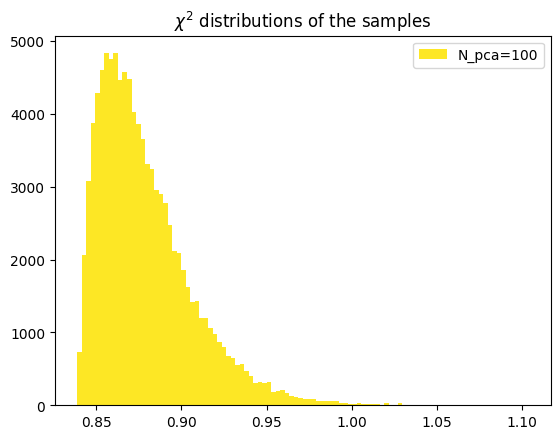

In [39]:
log_prob_samples_1 = sampler1.get_log_prob(discard=200, flat=True)
chi2_1 = -2*log_prob_samples_1/100
nc,bins,_=plt.hist(chi2_1[chi2_1<1.5],bins=100, color = colors[0], label = "N_pca=100")

plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

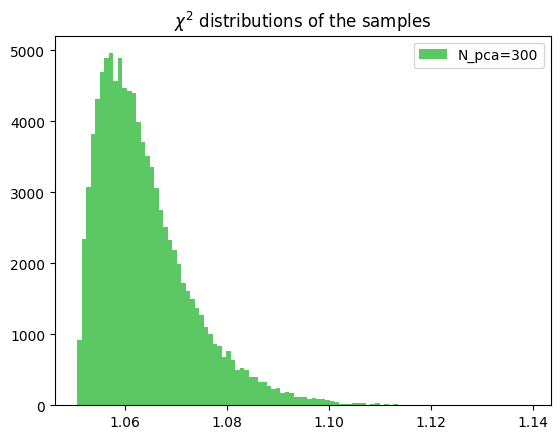

In [ ]:
log_prob_samples_2 = sampler2.get_log_prob(discard=200, flat=True)
chi2_2 = -2*log_prob_samples_2/300
nc,bins,_=plt.hist(chi2_2,bins=100, color = colors[1], label = "N_pca=300")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

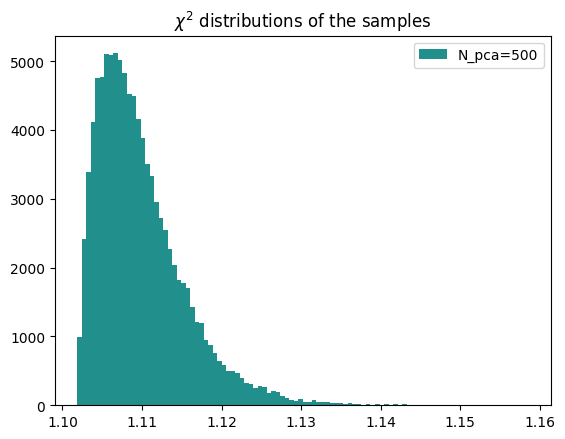

In [ ]:
log_prob_samples_3 = sampler3.get_log_prob(discard=200, flat=True)
chi2_3 = -2*log_prob_samples_3/500
nc,bins,_=plt.hist(chi2_3,bins=100, color = colors[2], label = "N_pca=500")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

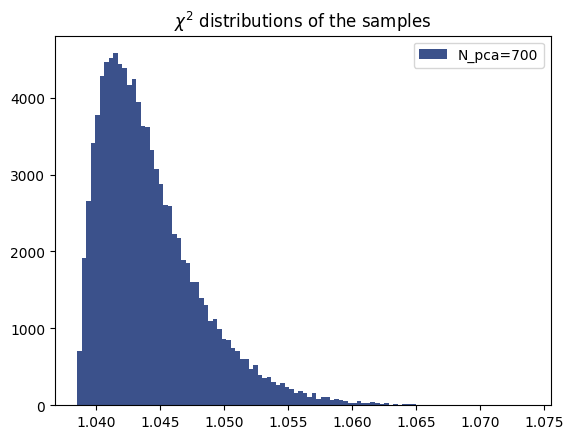

In [ ]:
log_prob_samples_4 = sampler4.get_log_prob(discard=200, flat=True)
chi2_4 = -2*log_prob_samples_4/700
nc,bins,_=plt.hist(chi2_4,bins=100, color = colors[3], label = "N_pca=700")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

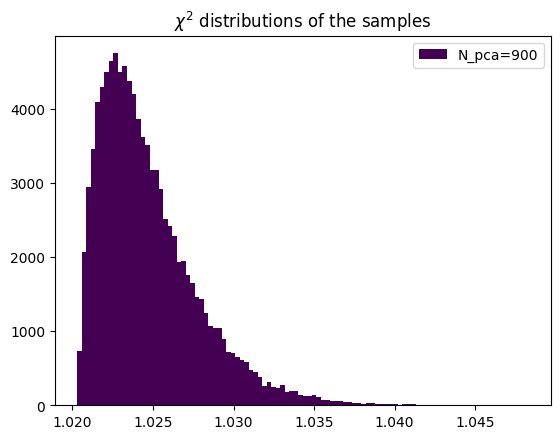

In [ ]:
log_prob_samples_5 = sampler5.get_log_prob(discard=200, flat=True)
chi2_5 = -2*log_prob_samples_5/900
nc,bins,_=plt.hist(chi2_5[chi2_5<1.05],bins=100, color = colors[4], label = "N_pca=900")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

#### _Link to assignment 2_
In assignment 2 we trained the neural network emulator (mine is performing pretty good, but here I still used the one given). After that, we used it to perform a Fisher analysis and estimate the error of two parameters, $\Omega_m$ and $w$. The goal was to test the input that a PCA analysis has on the error bars, so we performed the fisher analysis with an increasing number of PCA elements and looked into the error bars for the two previously-mentioned parameters.
The outcome of this analysis depends on the parameter considered, but what we saw is that $\approx 100$ PCA components account for 1% constraining power, while $\approx 400$ PCA elements retain 10% of the total constraining power.
In practice, we saw that with less and less PCA elements, the error bars were overestimated: this is exactly what we see happening here, with the error bars becoming tighter and tighter as the number of PCA elements increases.
It's also interesting to notice that not only the error bars change with number of PCA, but also the tilt of the contours changes slightly. This means that by removing too many PCA elements, some information about the correlations between parameters gets lost.

# Task 4
Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding  $\chi^2$  distributions?
- 4.a: Plot and compare the marginalised constraints on  $\Omega_m$  and  $A_s$ , as a function of the number of PCA elements. What do you observe?
- 4.b: To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5k covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on  $\Omega_m$  and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

## Using the 1.5k covariance matrix

In [40]:
from sklearn.decomposition import PCA
N_pca = 900
models = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/models.npy')
mean = np.mean(models,axis=0)
pca = PCA(n_components = N_pca, svd_solver='full')
models_pca = pca.fit_transform(models-mean)
rotation_matrix = pca.components_.T

In [41]:
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf

    return lnprior

## Function that computes the likelihood
def calc_likelihood_pca(para, reference_model, cov_inv, N_pca):

    params = {}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    features = cp_nn_model.predictions_np(params)[0]
    features = features*maximum+minimum
    pred_vector = pca.transform((features-mean).reshape(1,-1))[0,:N_pca]


    delta = (pred_vector - reference_model)
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [42]:
cov = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/cov_num_1500.npy')
n_r = 1500
n_d = 900
h = (n_r-n_d-2)/(n_r-1)
cov_inv = inv(cov)*h
cov_pca = rotation_matrix.T @ cov @ rotation_matrix

In [43]:
def run_mcmc_pca(N_pca, cov_pca, reference_model):
  n_r = 1500
  n_d = N_pca
  h = (n_r-n_d-2)/(n_r-1)
  inv_cov_pca = inv(cov_pca[:N_pca,:N_pca])*h
  reference_model = pca.transform((reference_model-mean).reshape(1,-1))[0,:N_pca]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood_pca, args=(reference_model, inv_cov_pca, N_pca))
  p0 = start_position_lh_and_step_size(654)
  sampler.run_mcmc(p0, 1200, progress='notebook')
  with open(f'drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_{str(N_pca)}.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Calculate chains

In [ ]:
run_mcmc_pca(100, cov_pca, reference_model)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(300, cov_pca, reference_model)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(700, cov_pca, reference_model)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(900, cov_pca, reference_model)

  0%|          | 0/1200 [00:00<?, ?it/s]

### Plot contours

In [44]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_100.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_300.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_500.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_700.pickle', 'rb') as f:
    sampler4 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_900.pickle', 'rb') as f:
    sampler5 = pickle.load(f)

In [45]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
flat_samples_3 = sampler3.get_chain(discard=200, flat=True)
flat_samples_4 = sampler4.get_chain(discard=200, flat=True)
flat_samples_5 = sampler5.get_chain(discard=200, flat=True)

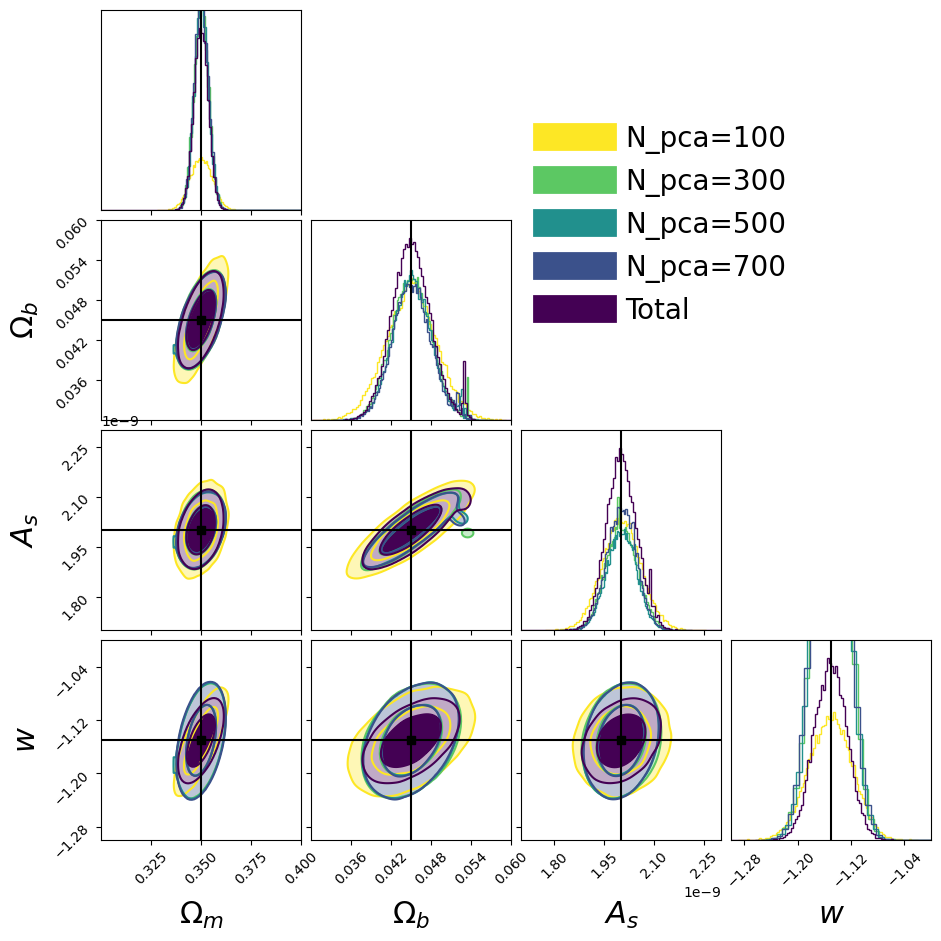

In [46]:
colors = mcp.gen_color(cmap="viridis_r",n=5)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_3,bins=100,labels=labels, color=colors[2], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_4,bins=100,labels=labels, color=colors[3], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_5,bins=100,labels=labels, color=colors[4], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3, truths = par_true, truth_color='black', range = [(0.30,0.4), (0.03,0.06), (1.70e-9,2.3e-9), (-1.3,-1.0)])


plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'N_pca=100',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'N_pca=300',linewidth=20),
                 Line2D([], [], color=colors[2], label=r'N_pca=500',linewidth=20),
                 Line2D([], [], color=colors[3], label=r'N_pca=700',linewidth=20),
                 Line2D([], [], color=colors[4], label=r'Total',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(0.4, 3.7, 0, 0)
    )

#### $\chi^2$ distributions

In [47]:
log_prob_samples_1 = sampler1.get_log_prob(discard=200, flat=True)
chi2_1 = -2*log_prob_samples_1/100
nc,bins,_=plt.hist(chi2_1[chi2_1<0.2],bins=100, color = colors[0], label = "N_pca=100")

plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

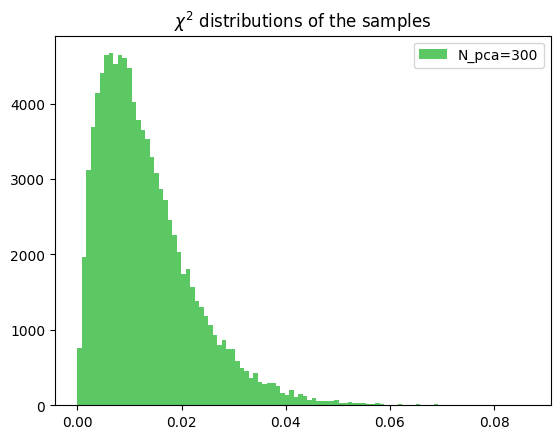

In [48]:
log_prob_samples_2 = sampler2.get_log_prob(discard=200, flat=True)
chi2_2 = -2*log_prob_samples_2/300
nc,bins,_=plt.hist(chi2_2[chi2_2<0.1],bins=100, color = colors[1], label = "N_pca=300")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

In [49]:
log_prob_samples_3 = sampler3.get_log_prob(discard=200, flat=True)
chi2_3 = -2*log_prob_samples_3/500
nc,bins,_=plt.hist(chi2_3[chi2_3<0.1],bins=100, color = colors[2], label = "N_pca=500")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

In [50]:
log_prob_samples_4 = sampler4.get_log_prob(discard=200, flat=True)
chi2_4 = -2*log_prob_samples_4/700
nc,bins,_=plt.hist(chi2_4[chi2_4<0.1],bins=100, color = colors[3], label = "N_pca=700")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

In [51]:
log_prob_samples_5 = sampler5.get_log_prob(discard=200, flat=True)
chi2_5 = -2*log_prob_samples_5/900
nc,bins,_=plt.hist(chi2_5[chi2_5<0.1],bins=100, color = colors[4], label = "N_pca=900")
plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

The only difference with respect to task 3 is that here I am using the noise free reference model instead of the noisy one. This explains why che chains exactly recover the true cosmology. Apart from that, we observe the same behaviour as before: using too little pca elelements cause a loss of constraining power (i.e.: the error bars are overestimated) and the tilt of the contours are slightly modified, indicating a different correlation between parameters.
The $\chi^2$ values are, however, very small: this is due to the fact that I'm using the reference model in the likelihood. This model is not noisy, so when evaluating the $\chi^2$ even small differences cause large deviation from the expected value. It's a behavior that is similar to overfitting, because such a likelihood is built to have a minimum in the true cosmology.

## Using the analytical covariance matrix (this was not required, it was only the 1.5k covariance matrix)

In [ ]:
from sklearn.decomposition import PCA
N_pca = 900
models = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/models.npy')
mean = np.mean(models,axis=0)
pca = PCA(n_components = N_pca, svd_solver='full')
models_pca = pca.fit_transform(models-mean)
rotation_matrix = pca.components_.T

In [ ]:
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf

    return lnprior

## Function that computes the likelihood
def calc_likelihood_pca(para, reference_model, cov_inv, N_pca):

    params = {}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    features = cp_nn_model.predictions_np(params)[0]
    features = features*maximum+minimum
    pred_vector = pca.transform((features-mean).reshape(1,-1))[0,:N_pca]


    delta = (pred_vector - reference_model)
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [ ]:
cov=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/covariance.npy')
cov_inv = inv(cov)
cov_pca = rotation_matrix.T @ cov @ rotation_matrix

In [ ]:
def run_mcmc_pca(N_pca, cov_pca, reference_model):
  inv_cov_pca = inv(cov_pca[:N_pca,:N_pca])
  reference_model = pca.transform((reference_model-mean).reshape(1,-1))[0,:N_pca]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood_pca, args=(reference_model, inv_cov_pca, N_pca))
  p0 = start_position_lh_and_step_size(654)
  sampler.run_mcmc(p0, 2200, progress='notebook')
  with open(f'drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_analytic_pca_{str(N_pca)}.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Run Chains

In [ ]:
run_mcmc_pca(100, cov_pca, reference_model)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(200, cov_pca, reference_model)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(300, cov_pca, reference_model)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(700, cov_pca, reference_model)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(900, cov_pca, reference_model)

  0%|          | 0/2200 [00:00<?, ?it/s]

### Plot results

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_analytic_pca_100.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_analytic_pca_200.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_analytic_pca_300.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_analytic_pca_500.pickle', 'rb') as f:
    sampler4 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_analytic_pca_700.pickle', 'rb') as f:
    sampler5 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_analytic_pca_900.pickle', 'rb') as f:
    sampler6 = pickle.load(f)

In [ ]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
flat_samples_3 = sampler3.get_chain(discard=200, flat=True)
flat_samples_4 = sampler4.get_chain(discard=200, flat=True)
flat_samples_5 = sampler5.get_chain(discard=200, flat=True)
flat_samples_6 = sampler6.get_chain(discard=200, flat=True)

In [ ]:
colors = mcp.gen_color(cmap="viridis_r",n=6)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_3,bins=100,labels=labels, color=colors[2], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_4,bins=100,labels=labels, color=colors[3], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_5,bins=100,labels=labels, color=colors[4], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_6,bins=100,labels=labels, color=colors[5], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3, truths = par_true, truth_color='black', range = [(0.325,0.375), (0.034,0.056), (1.80e-9,2.2e-9), (-1.3,-1.0)])



plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'N_pca=100',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'N_pca=200',linewidth=20),
                 Line2D([], [], color=colors[2], label=r'N_pca=300',linewidth=20),
                 Line2D([], [], color=colors[3], label=r'N_pca=500',linewidth=20),
                 Line2D([], [], color=colors[4], label=r'N_pca=700',linewidth=20),
                 Line2D([], [], color=colors[5], label=r'Total',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(0.4, 3.7, 0, 0)
    );

In [ ]:
log_prob_samples_1 = sampler1.get_log_prob(discard=200, flat=True)
chi2_1 = -2*log_prob_samples_1/900
nc,bins,_=plt.hist(chi2_1,bins=100, color = colors[0], label = "N_pca=100")

log_prob_samples_2 = sampler2.get_log_prob(discard=200, flat=True)
chi2_2 = -2*log_prob_samples_2/900
nc,bins,_=plt.hist(chi2_2,bins=100, color = colors[1], label = "N_pca=200")

log_prob_samples_3 = sampler3.get_log_prob(discard=200, flat=True)
chi2_3 = -2*log_prob_samples_3/900
nc,bins,_=plt.hist(chi2_3,bins=100, color = colors[2], label = "N_pca=300")

log_prob_samples_4 = sampler4.get_log_prob(discard=200, flat=True)
chi2_4 = -2*log_prob_samples_4/900
nc,bins,_=plt.hist(chi2_4,bins=100, color = colors[3], label = "N_pca=500")

log_prob_samples_5 = sampler5.get_log_prob(discard=200, flat=True)
chi2_5 = -2*log_prob_samples_5/900
nc,bins,_=plt.hist(chi2_5,bins=100, color = colors[4], label = "N_pca=700")

log_prob_samples_6 = sampler6.get_log_prob(discard=200, flat=True)
chi2_6 = -2*log_prob_samples_6/900
nc,bins,_=plt.hist(chi2_6,bins=100, color = colors[5], label = "N_pca=900")


plt.title(r"$\chi^2$ distributions of the samples")
plt.legend()
plt.show()

## Task 4.a: marginalized constraints of $\Omega_m$ and $A_s$

In [ ]:
def get_marg_constr(sampler):
  flat_samples = sampler.get_chain(discard=200, flat=True)
  mcmc_om = np.percentile(flat_samples[:, 0], [16, 50, 84])
  sigma_om = np.diff(mcmc_om)[0]
  mcmc_as = np.percentile(flat_samples[:, 2], [16, 50, 84])
  sigma_as = np.diff(mcmc_as)[0]
  return [mcmc_om[1], mcmc_as[1]] , [sigma_om, sigma_as]

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_100.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_300.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_500.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_700.pickle', 'rb') as f:
    sampler4 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4_pca_900.pickle', 'rb') as f:
    sampler5 = pickle.load(f)

samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

In [ ]:
sigmas = np.zeros((5,2))
constraints = np.zeros((5,2))
for i in range(5):
  constraints[i,:], sigmas[i,:] = get_marg_constr(samplers[i])

In [ ]:
pcas = [100, 300, 500, 700, 900]
plt.title(r"$\Omega_m$ vs number of PCA elements" )
plt.errorbar(pcas, constraints[:,0] ,yerr=sigmas[:,0], color = 'navy', label="1.5k cov", marker='.')
plt.legend()
plt.xlabel("N_pca")
plt.ylabel(r"$\sigma$");

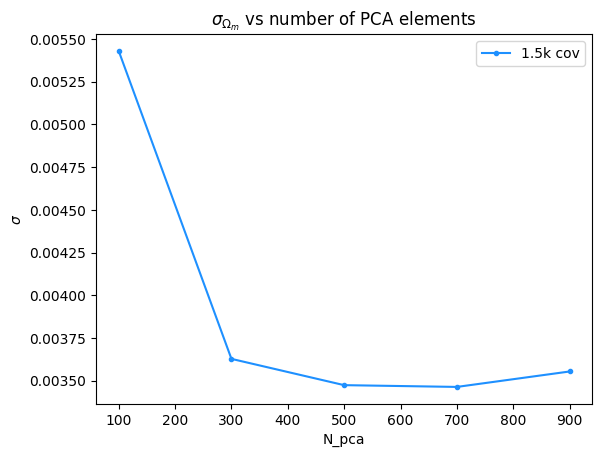

In [ ]:
pcas = [100, 300, 500, 700, 900]
plt.title(r"$\sigma_{\Omega_m}$ vs number of PCA elements" )
plt.plot(pcas, sigmas[:,0], color = 'dodgerblue', label="1.5k cov", marker='.')
plt.legend()
plt.xlabel("N_pca")
plt.ylabel(r"$\sigma$");

In [ ]:
plt.errorbar(pcas, constraints[:,1], yerr=sigmas[:,1], color="navy", label="1.5k cov", marker='.')
plt.title(r"$A_s$ vs number of PCA elements" )
plt.legend()
plt.xlabel("N_pca")
plt.ylabel(r"$\sigma$");

In [ ]:
plt.plot(pcas, sigmas[:,1], color="dodgerblue", label="1.5k cov", marker='.')
plt.title(r"$\sigma_{A_s}$ vs number of PCA elements" )
plt.legend()
plt.xlabel("N_pca")
plt.ylabel(r"$\sigma$");

As expected, the error bars become smaller when using more PCA elements. This makes sense as by including more elements I'm using more information, so the constraining power increases.

## Task 4.b: multiple chains for the same number of PCA elements

In [ ]:
cov = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/cov_num_1500.npy')
n_r = 1500
n_d = 900
h = (n_r-n_d-2)/(n_r-1)
cov_inv = inv(cov)*h
cov_pca = rotation_matrix.T @ cov @ rotation_matrix

In [ ]:
def run_mcmc_pca(N_pca, cov_pca, reference_model, seed):
  n_r = 1500
  n_d = N_pca
  h = (n_r-n_d-2)/(n_r-1)
  inv_cov_pca = inv(cov_pca[:N_pca,:N_pca])*h
  reference_model = pca.transform((reference_model-mean).reshape(1,-1))[0,:N_pca]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=calc_likelihood_pca, args=(reference_model, inv_cov_pca, N_pca))
  p0 = start_position_lh_and_step_size(seed)
  sampler.run_mcmc(p0, 1200, progress='notebook')
  with open(f'drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4B_pca_{str(seed)}.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Run chains

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model, 55)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model, 89)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model, 144)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
run_mcmc_pca(500, cov_pca, reference_model, 233)

  0%|          | 0/1200 [00:00<?, ?it/s]

### Analyze chains

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4B_pca_55.pickle', 'rb') as f:
    sampler1 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4B_pca_89.pickle', 'rb') as f:
    sampler2 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4B_pca_144.pickle', 'rb') as f:
    sampler3 = pickle.load(f)

with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task4B_pca_233.pickle', 'rb') as f:
    sampler4 = pickle.load(f)

In [ ]:
flat_samples_1 = sampler1.get_chain(discard=200, flat=True)
flat_samples_2 = sampler2.get_chain(discard=200, flat=True)
flat_samples_3 = sampler3.get_chain(discard=200, flat=True)
flat_samples_4 = sampler4.get_chain(discard=200, flat=True)

In [ ]:
colors = mcp.gen_color(cmap="viridis_r",n=4)
figure = corner.corner(flat_samples_1,bins=100, labels=labels, color=colors[0], label_kwargs={"fontsize": 22},levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_2,bins=100,labels=labels, color=colors[1], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3)
corner.corner(flat_samples_3,bins=100,labels=labels, color=colors[2], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=2)
corner.corner(flat_samples_4,bins=100,labels=labels, color=colors[3], label_kwargs={"fontsize": 22}, fig=figure,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3, range = [(0.32,0.39), (0.033,0.056), (1.80e-9,2.2e-9), (-1.30,-1.0)])


plt.legend(
        handles=[Line2D([], [], color=colors[0], label=r'Run 1',linewidth=20),
                 Line2D([], [], color=colors[1], label=r'Run 2',linewidth=20),
                 Line2D([], [], color=colors[2], label=r'Run 3',linewidth=20),
                 Line2D([], [], color=colors[3], label=r'Run 4',linewidth=20)
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(0.4, 3.7, 0, 0)
    )

In [ ]:
sigmas = np.zeros((4,2))
samplers = [sampler1, sampler2, sampler3, sampler4]
for i in range(4):
  _, sigmas[i,:] = get_marg_constr(samplers[i])

The standard deviation between the sigmas is  5.006376571458824e-05 



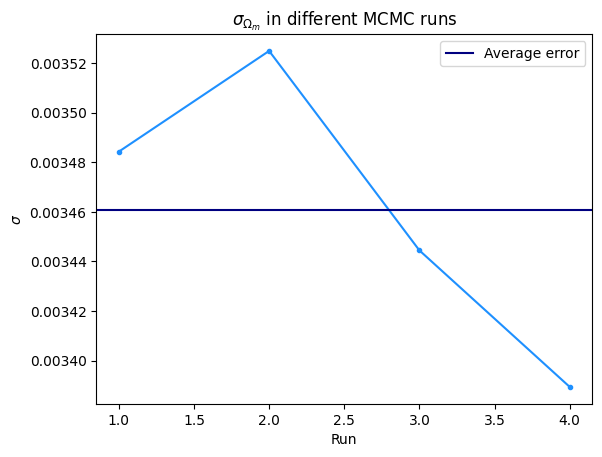

In [ ]:
plt.title(r"$\sigma_{\Omega_m}$ in different MCMC runs" )
plt.plot(np.arange(1,5), sigmas[:,0], color = 'dodgerblue', marker='.')
plt.axhline(np.mean(sigmas[:,0]), color="navy", label = "Average error")
plt.xlabel("Run")
plt.legend()
plt.ylabel(r"$\sigma$")
print("The standard deviation between the sigmas is ", np.sqrt(np.var(sigmas[:,0])), "\n")

The standard deviation between the sigmas is  1.0468607642455222e-12 



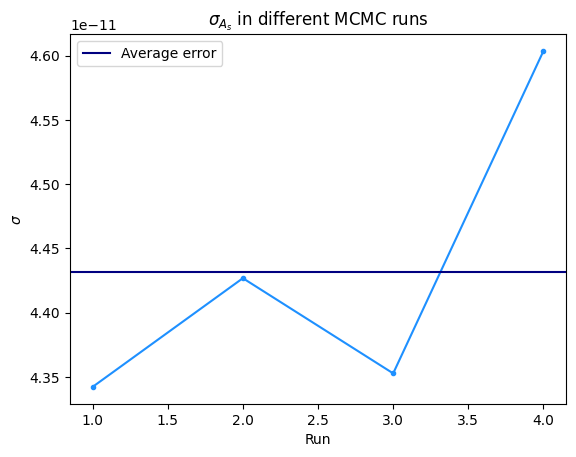

In [ ]:
plt.title(r"$\sigma_{A_s}$ in different MCMC runs" )
plt.plot(np.arange(1,5), sigmas[:,1], color = 'dodgerblue', marker='.')
plt.axhline(np.mean(sigmas[:,1]), color="navy", label = "Average error")
plt.xlabel("Run")
plt.legend()
plt.ylabel(r"$\sigma$")
print("The standard deviation between the sigmas is ", np.sqrt(np.var(sigmas[:,1])), "\n")

I run 4 chains with 500 PCA elements a different random seeds. As visible from the cornerplot, the contours obtained in each case are sligthly different (as expected). The plots above show the estimates of the error bars for the different chains: there is some scatter, but the error on the sigmas only affects the second or third significant digit so the scatter is very small. This suggests that the sampling is pretty robust. However, to get even more reliable estimates of the error bars it would be better to average over a few realizations of the MCMC chains. In that way, the error bars would also account for the intrinsic scatter of the chains, which are stochastic.

# Task 5
Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.

In [ ]:
import zeus

In [ ]:
cov=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/covariance.npy')
cov_inv = inv(cov)
reference_model_noisy = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment3/reference_model_noise.npy')

In [ ]:
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf

    return lnprior

## Function that computes the likelihood
def calc_likelihood(para, reference_model, cov_inv):

    params = {}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum

    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)

    delta = pred_vector - reference_model
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [ ]:
def start_position_gaussian(seed, sigmas=[0.02, 0.002, 0.2e-9, 0.2]):
    np.random.seed(seed)
    p0 = []
    for i in range(nwalkers):
        gaussian_starts = []
        for true_val, sigma in zip(par_true, sigmas):
            start_val = np.random.normal(true_val, sigma)
            gaussian_starts.append(start_val)
        p0.append(gaussian_starts)
    return np.array(p0)

Initializing the walkers using a Gaussian distribution around the true cosmology is very helpful as it's way less likely for the walkers to get stuck in local minima. Looking back, I would also use this initialization with emcee but I don't have the time now. The zeus sampler is very sensitive to the initialization: the chain runs faster when the walkers are initialized in that way.

### Run Chain

With emcee, the average autocorrelation time is $\approx 40$ steps. A test run with zeus showed that the autocorrelation time is $\approx 8$ steps with this algorithm. In order to have the same number of indipendent samples, it's sufficient to run a zeus chain with $≈ 400 $ steps. I then remove the first $100$ as burn-in.

In [ ]:
nsteps, nwalkers, ndim = 600, 100, 4
start = start_position_gaussian(654)
sampler = zeus.EnsembleSampler(nwalkers, ndim, calc_likelihood, args=[reference_model_noisy, cov_inv])

In [ ]:
sampler.run_mcmc(start, nsteps)

Initialising ensemble of 100 walkers...
Sampling progress : 100%|██████████| 600/600 [47:07<00:00,  4.71s/it]


In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task5.pickle', 'wb') as f:
    pickle.dump(sampler, f)

### Analyze chain

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task5.pickle', 'rb') as f:
    sampler = pickle.load(f)

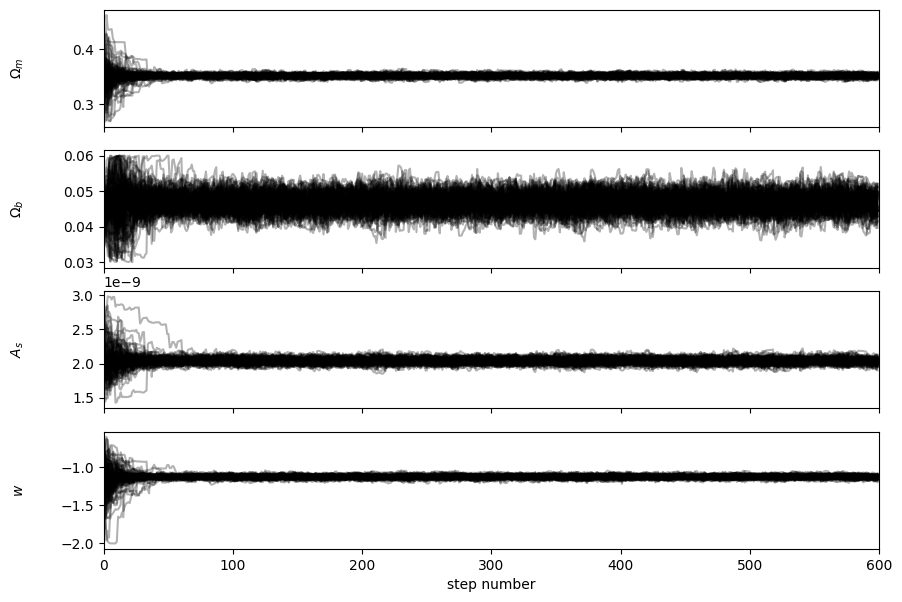

In [ ]:
ndim = 4 #parameters
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr

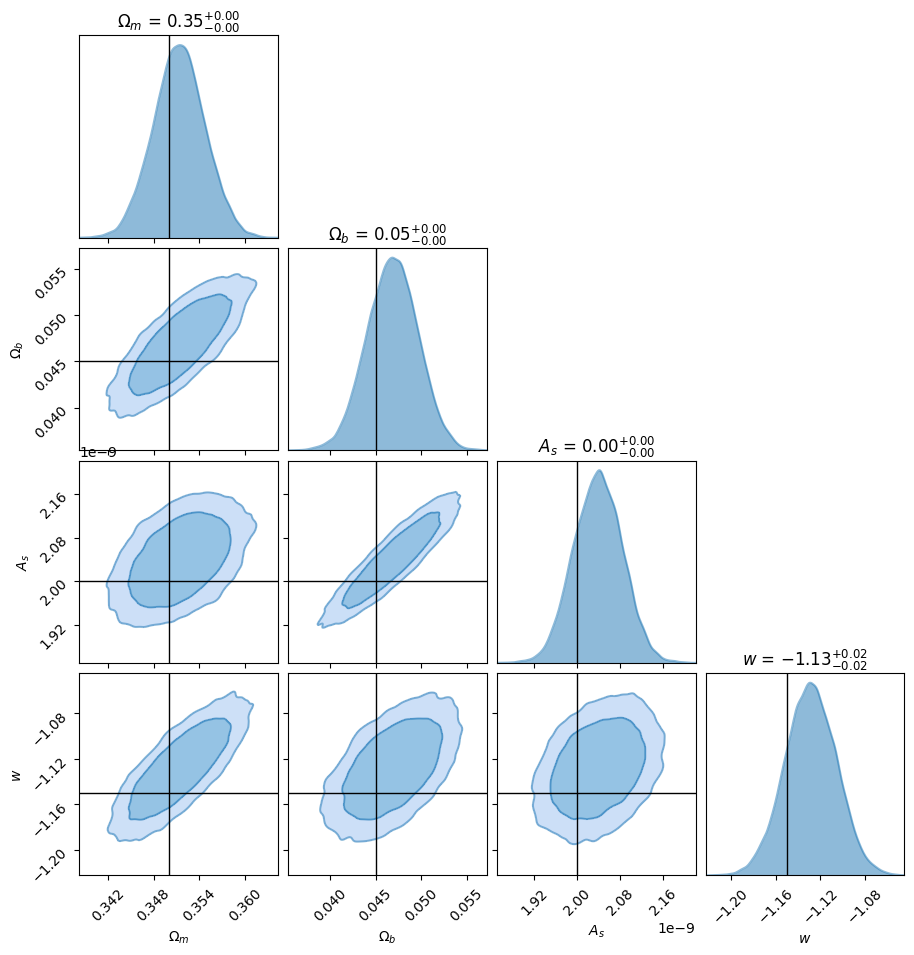

In [ ]:
flat_samples = sampler.get_chain(discard=200, thin=1, flat=True)
fig, axes = zeus.cornerplot(flat_samples, labels=labels, levels=[0.025, 0.16], quantiles=[0.16, 0.5, 0.84], truth = par_true);

In [ ]:
with open('drive/MyDrive/Colab Notebooks/data_4_assignment3/outputs_MCMC/mcmc_results_task1.pickle', 'rb') as f:
    sampler_emcee = pickle.load(f)

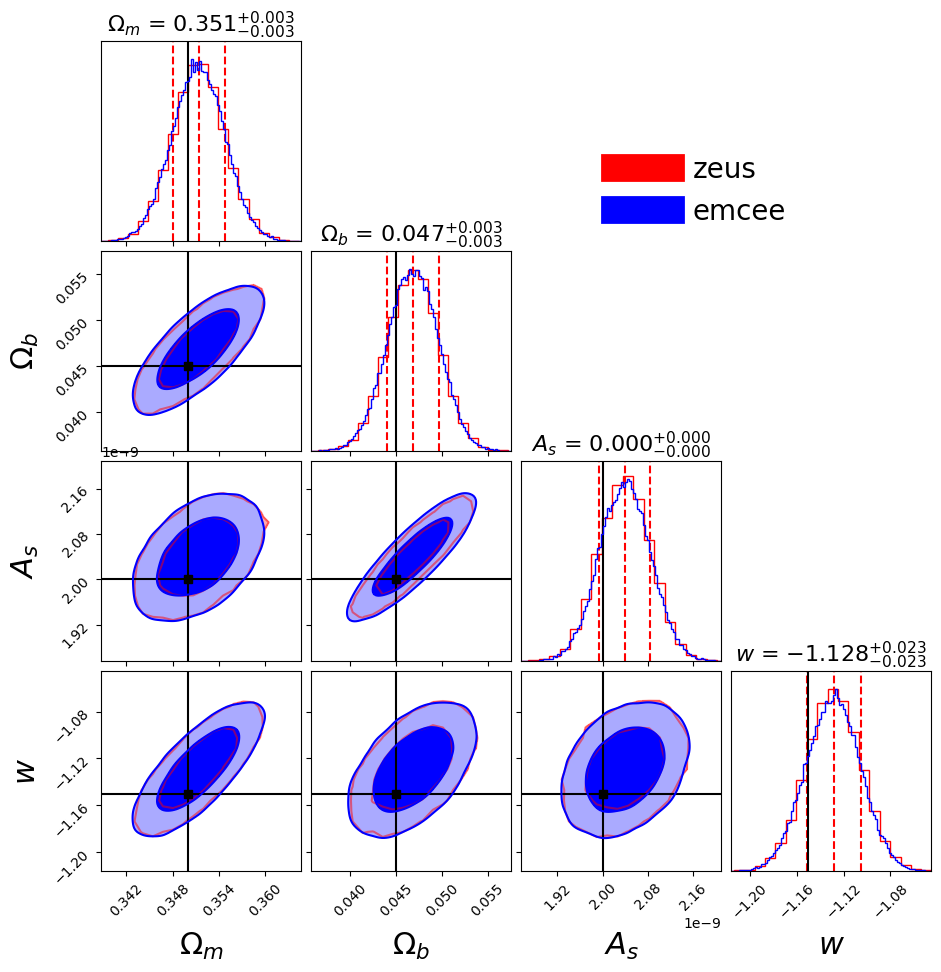

In [ ]:
flat_samples = sampler.get_chain(discard=200, thin=1, flat=True)
flat_samples_emcee = sampler_emcee.get_chain(discard=200, thin=1, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, color="red",
    plot_contours=True, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68, 0.95),
    title_kwargs={"fontsize": 16}, label_kwargs={"fontsize": 22}, title_fmt=".3f",
    fill_contours=True, contour_kwargs={"alpha": 0.5},plot_datapoints=False, truths = par_true, truth_color='black'
)
corner.corner(flat_samples_emcee,bins=100,labels=labels, color="blue", label_kwargs={"fontsize": 22}, fig=fig,levels=(0.68, 0.95),
    fill_contours=True,plot_datapoints=False, smooth=3,range=[0.9999] * 4)

plt.legend(
        handles=[Line2D([], [], color="red", label=r'zeus',linewidth=20),
                 Line2D([], [], color="blue", label=r'emcee',linewidth=20),
        ],
        fontsize=20, frameon=False, bbox_to_anchor=(0.4, 3.7, 0, 0)
    );

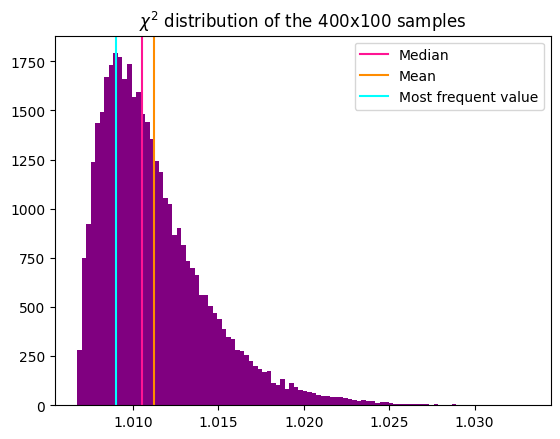

In [ ]:
log_prob_samples = sampler.get_log_prob(discard=200, flat=True)
chi2 = -2*log_prob_samples/900
nc,bins,_=plt.hist(chi2,bins=100, color = "purple")
plt.axvline(np.median(chi2), color="deeppink", label="Median")
plt.axvline(np.mean(chi2), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.title(r"$\chi^2$ distribution of the 400x100 samples")
plt.legend()
plt.show()

In [ ]:
print("Median: ", np.median(chi2))
print("Mean: ", np.mean(chi2))
print("Most frequent value: ", (bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2.)

Median:  1.0105121489830404
Mean:  1.0112348058143676
Most frequent value:  1.0090012853610806


Zeus is a sampler with the same API as emcee, but that uses a different algorithm (ensemble slice sampling). This algorithm is better than emcee in producing uncorrelated samples, this means that to obtain the same number of independent samples the chain needs less steps. However, it is slower. This sampler also seems to be more dependent on the walkers' initialization: the chain runs faster when the walkers are initialized in the proximity of the true cosmology.